In [1]:
3+6

9

# Master File

# Tools & Libraries

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [3]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (boxplot_histogram)

from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx,
    store_bin
    )


In [4]:
from pa_lib.data import desc_col

In [5]:
from IPython.display import display
pd.options.display.max_columns = None


In [6]:
# Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

########################################################################################
## Recursive Dependency Check:
request_job(job_name="ek_info_prepare.py", current= "Today") # output: ek_info.feather

11:44:18 [INFO] [ipykernel_launcher.py] requests 'ek_info_prepare.py'
11:44:18 [INFO] [ipykernel_launcher.py]: Running job 'ek_info_prepare.py': Run result is out of date ('Today')
12:20:03 [INFO] [ipykernel_launcher.py]: Job 'ek_info_prepare.py' finished successfully!


# Load Dataset (Data Preparation)

In [7]:
from vkprog_data_prep import bd_train_scoring


12:20:03 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
12:20:03 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-06 12:15:44.904593.


http://www.whatweekisit.org/

In [8]:
%%time
# Wall time: 38.5 s

# 2019-10-21 => Calendar week 43
(training_all, scoring_all, feature_colnames_bd, feature_colnames_dates,feature_colnames_branchen) = bd_train_scoring(
    day=1,
    month=7,
    year_score=2019,
    year_train=2018,
    year_span=4,
    sales_filter=False, ## Schmeisst gewisse Kunden direkt raus. (Hat nix mit Annulationen zu tun)
    scale_features=True)

12:20:03 [INFO] Started loading binary file
12:20:03 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
12:20:03 [INFO] Finished loading binary file in 0.18s (0.77s CPU)
12:20:04 [INFO] False: Filters applied, defined by Sales
12:20:04 [INFO] Period: KW_2
12:20:04 [INFO] Calculate Reservation...
12:20:05 [INFO] Calculate Aushang...
12:20:05 [INFO] Merge Results...
12:20:05 [INFO] aggregate_bookings: Done.
12:20:05 [INFO] current_yyyykw: 201927
12:20:05 [INFO] training_yyyykw:201827
12:20:05 [INFO] Computing: Pivot Table
12:20:06 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
12:20:06 [INFO] Computing: Yearly total sums
12:20:06 [INFO] Merging: Left-Join to Container dataframe
12:20:06 [INFO] Merging: Left-Join to Container dataframe
12:20:06 [INFO] Merging: Left-Join to Container dataframe
12:20:06 [INFO] Merging: Left-Join to Container dataframe
12:20:06 [INFO] Final merge
12:20:06 [INFO] Computing: Pivot Table
12:20:06 [INFO] Running: booking_yearly_totals(Y

In [9]:
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())


training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,N


scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31,Netto_Sum_Res_RY_2_KW_33,Netto_Sum_Res_RY_2_KW_35,N

In [10]:
set(training_all.columns == scoring_all.columns)

{True}

In [11]:
# Search for NULLS
display(desc_col(training_all)
        .sort_values("NULLS", ascending=False)
        .head(5)
        )

display(desc_col(scoring_all)
        .sort_values("NULLS", ascending=False)
        .head(5)
       )

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/18059,18059
Netto_Sum_Res_RY_4_KW_33,float64,0/18059,332
Netto_Sum_Res_RY_4_KW_47,float64,0/18059,355
Netto_Sum_Res_RY_4_KW_45,float64,0/18059,407
Netto_Sum_Res_RY_4_KW_43,float64,0/18059,526


,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/18122,18122
Netto_Sum_Res_RY_4_KW_33,float64,0/18122,318
Netto_Sum_Res_RY_4_KW_47,float64,0/18122,367
Netto_Sum_Res_RY_4_KW_45,float64,0/18122,382
Netto_Sum_Res_RY_4_KW_43,float64,0/18122,510


In [12]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

Target_Res_flg == False


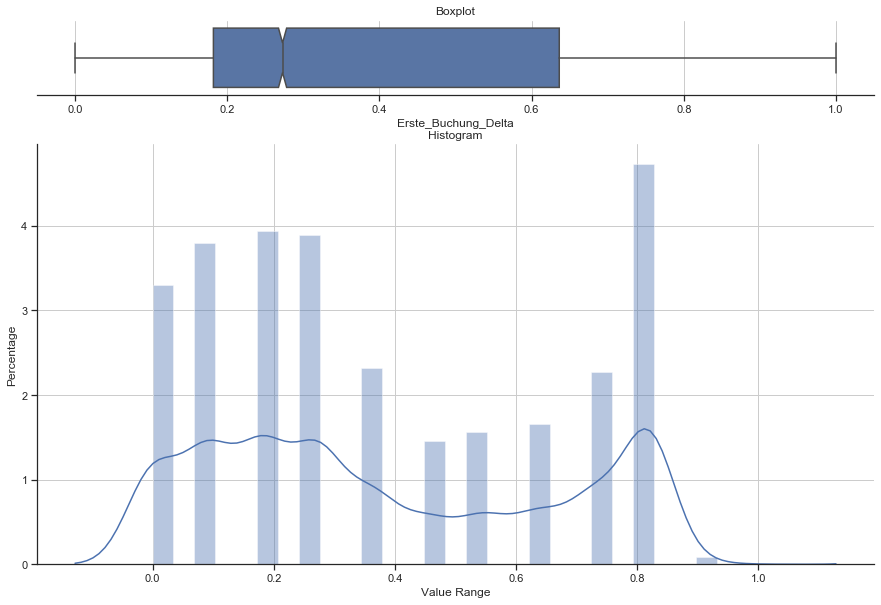

Target_Res_flg == True


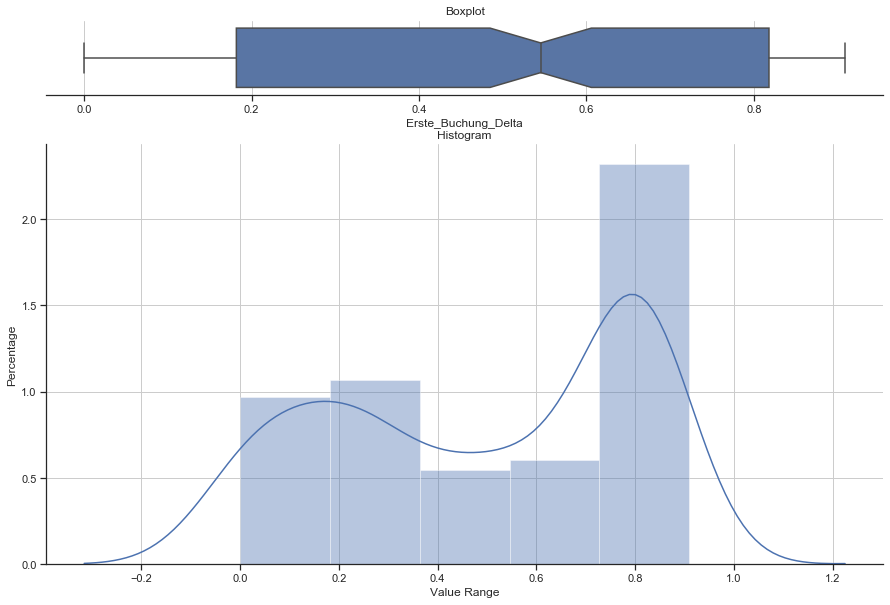

Target_Res_flg == False


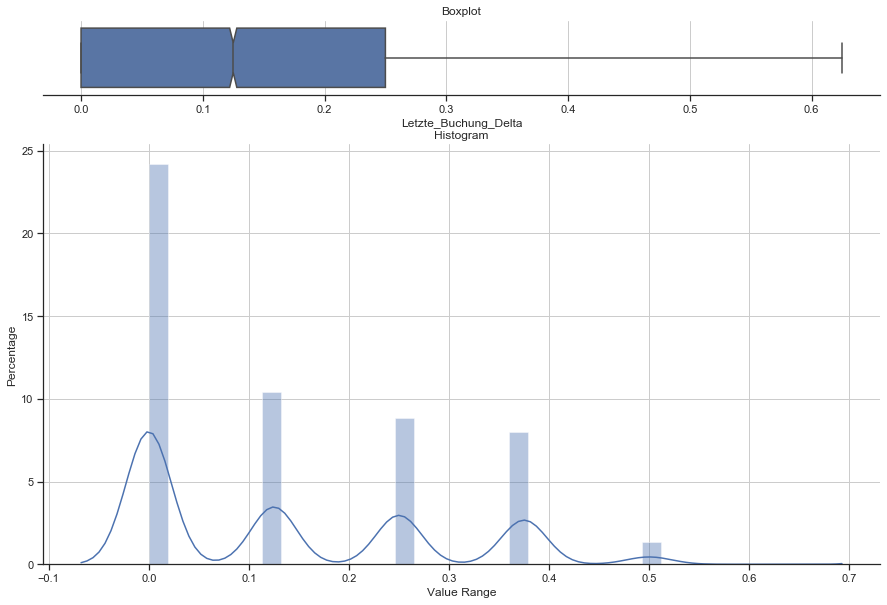

Target_Res_flg == True


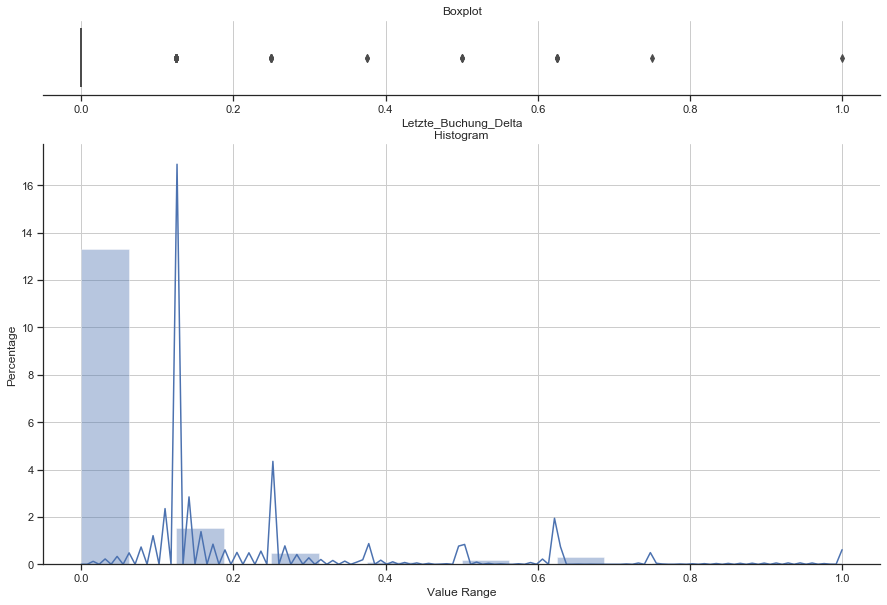

Target_Res_flg == False


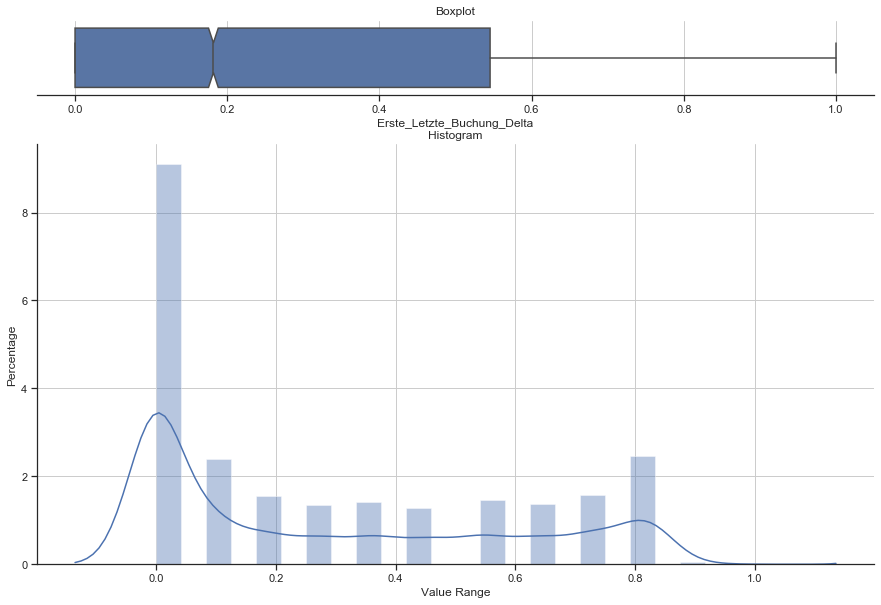

Target_Res_flg == True


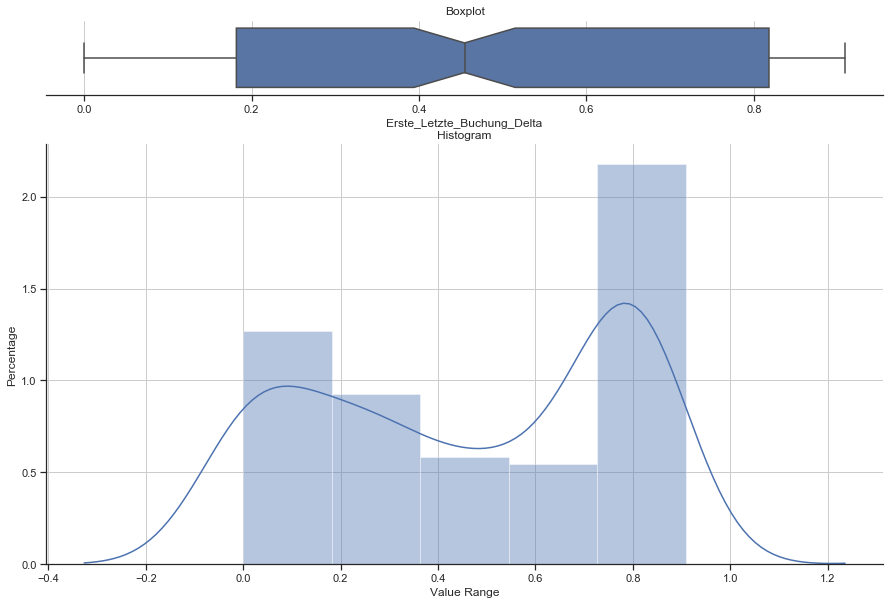

In [13]:
temp_df = training_all
print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Buchung_Delta"])

print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Letzte_Buchung_Delta"])


print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Letzte_Buchung_Delta"])

## CRM Data

In [14]:
from vkprog_crm_prep  import crm_train_scoring

12:20:40 [INFO] [ipykernel_launcher.py] requests 'crm_prepare.py'
12:20:40 [INFO] [ipykernel_launcher.py]: Not running job 'crm_prepare.py': result is current ('Today') from 2019-11-06 11:48:34.131150.


In [15]:
(crm_train_df, crm_score_df,feature_colnames_crm) = crm_train_scoring(
    day=1,
    month=7,
    year_score=2019,
    year_train=2018,
    year_span=4)

12:20:40 [INFO] Start.
12:20:40 [INFO] Started loading binary file
12:20:40 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
12:20:41 [INFO] Finished loading binary file in 0.22s (0.25s CPU)
12:20:51 [INFO] Finished.


In [16]:
from pa_lib.data import desc_col

In [17]:
def scaling_crm_add2master(master_df,crm_df,feature_colnames_crm):
    
    container_df = pd.merge(master_df, crm_df,how="left", on="Endkunde_NR")

    for col_name in list(np.compress(['RY'== x[0:2] for x in feature_colnames_crm],feature_colnames_crm)):
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(0)
        max_ = np.nanmax(container_df.loc[:,col_name])
        min_ = np.nanmin(container_df.loc[:,col_name])
        if min_ == max_:
            container_df.loc[:,col_name] = 0
        else:
            container_df.loc[:,col_name] = (container_df.loc[:,col_name] - min_)/(max_ - min_)

    for col_name in list(np.compress(['Letzter'== x[0:7] for x in feature_colnames_crm],feature_colnames_crm)):
        max_ = np.nanmax(container_df.loc[:,col_name]) # those who have never been contacted will be put together with the max-ones.
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(max_) # No more NaNs!
        min_ = np.nanmin(container_df.loc[:,col_name])
        
        if max_ == min_:
            container_df.loc[:,col_name] = 1
        else:
            container_df.loc[:,col_name] = container_df.loc[:,col_name]/max_ # scaling, doesn't need 0
    
    return container_df

In [18]:
training_all = scaling_crm_add2master(master_df            = training_all,
                                          crm_df               = crm_train_df,
                                          feature_colnames_crm = feature_colnames_crm)

In [19]:
scoring_all  = scaling_crm_add2master(master_df=scoring_all, crm_df=crm_score_df,feature_colnames_crm=feature_colnames_crm)

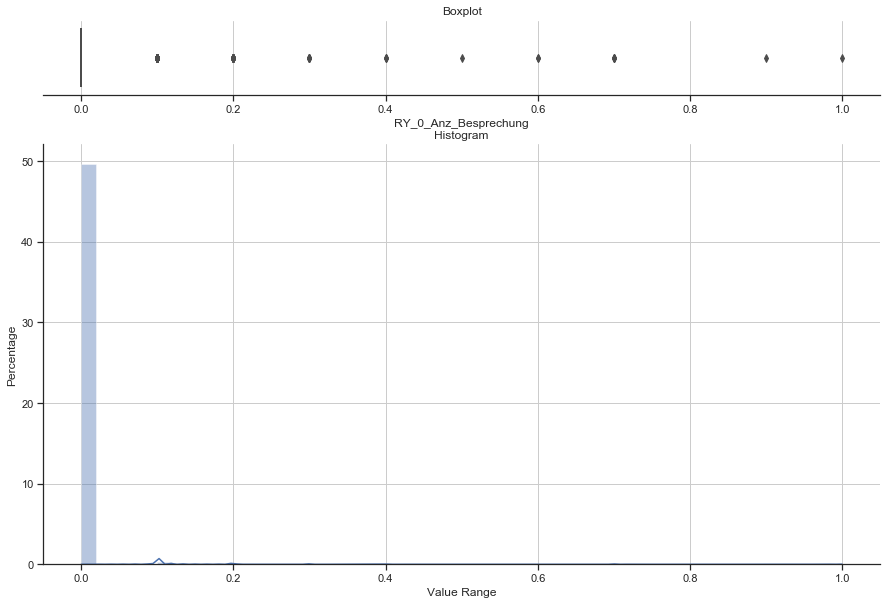

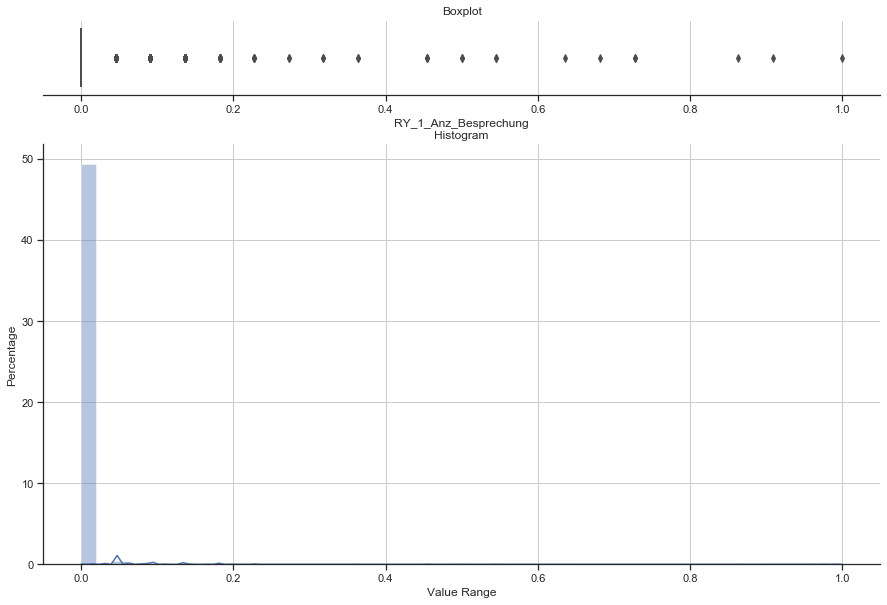

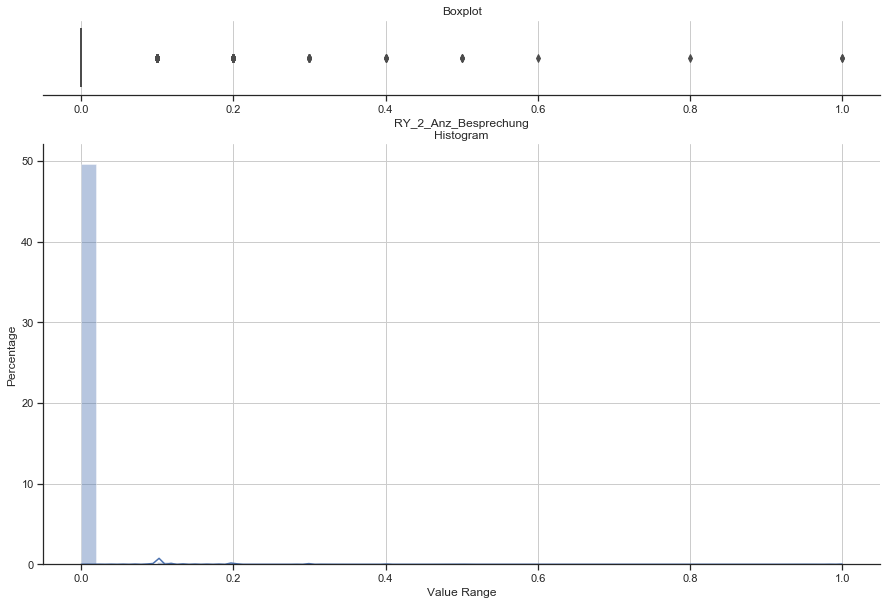

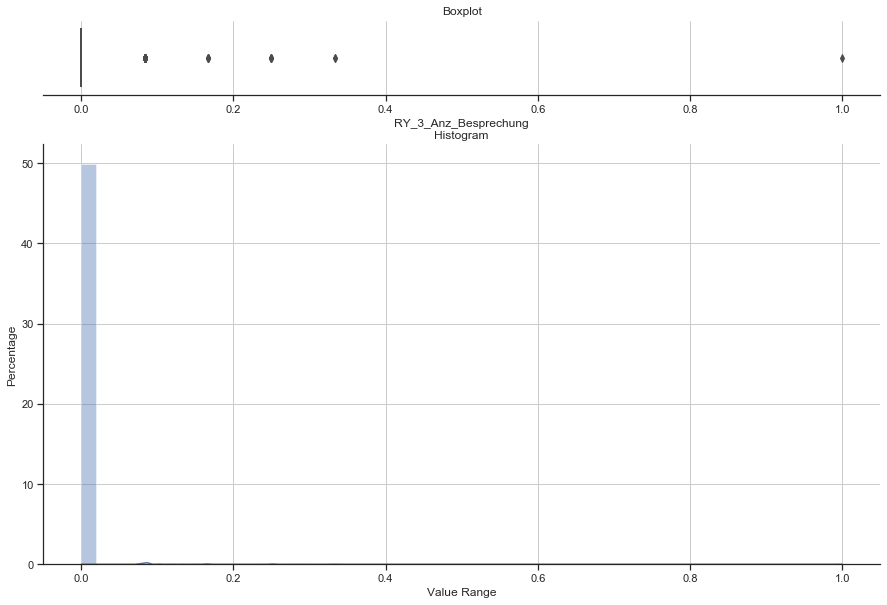

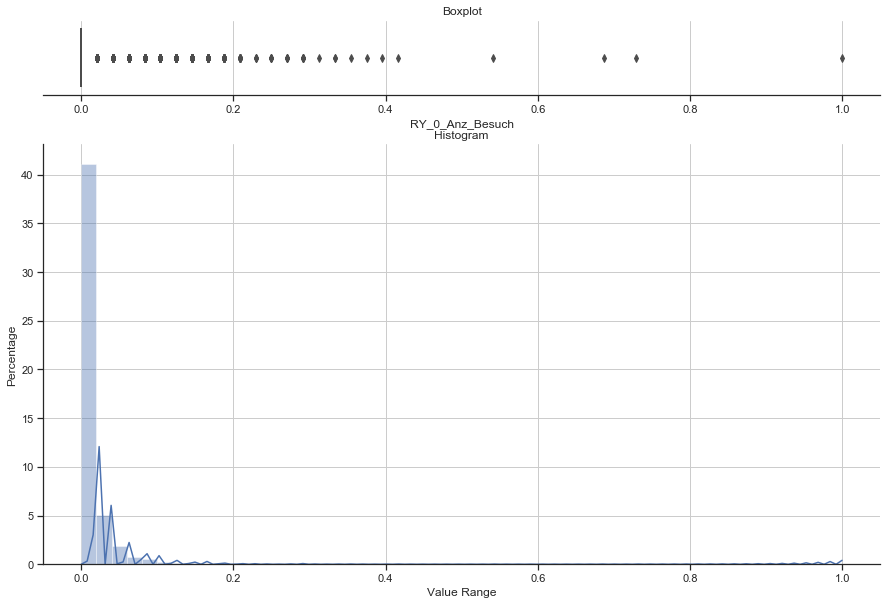

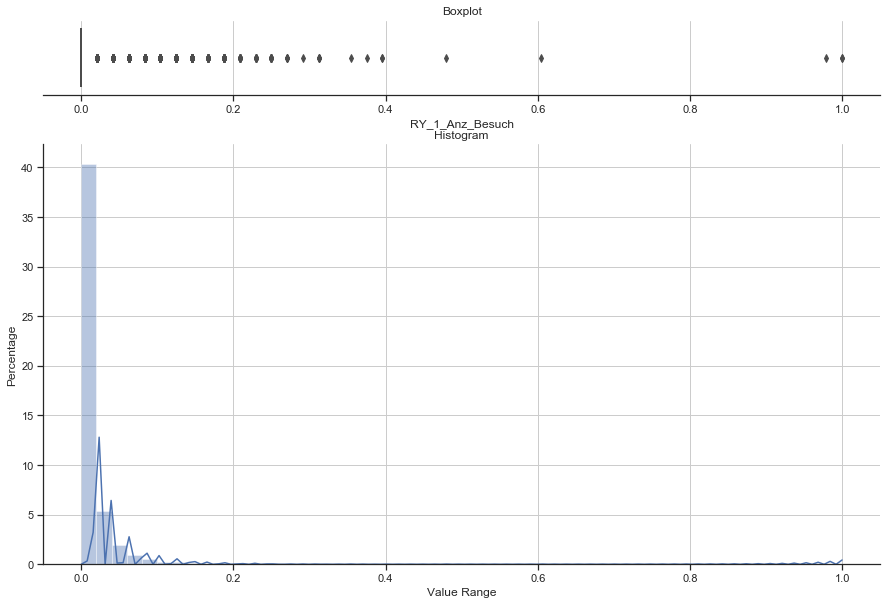

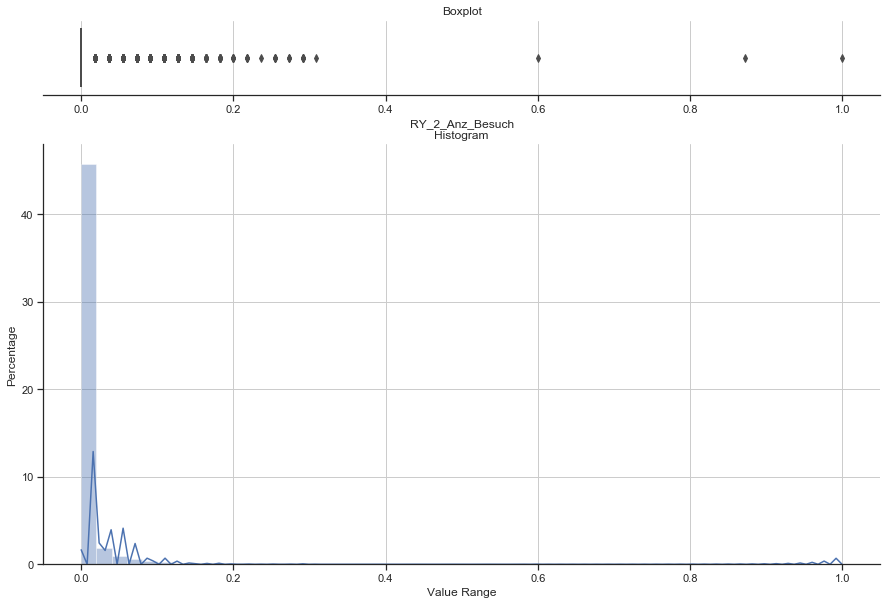

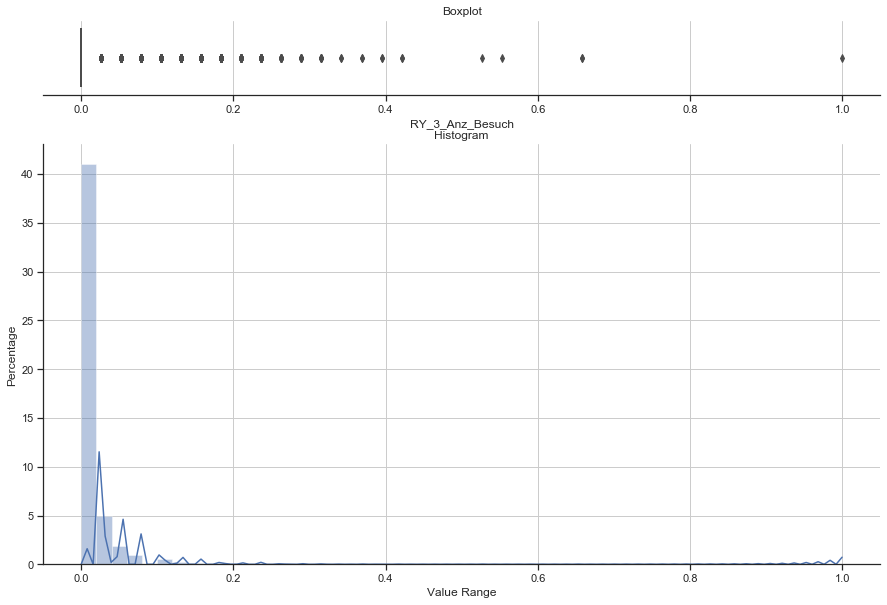

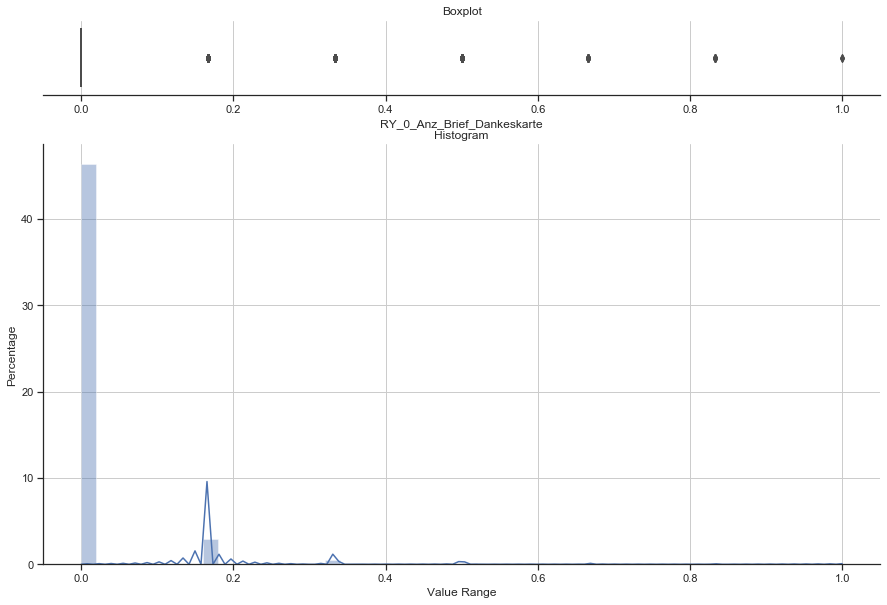

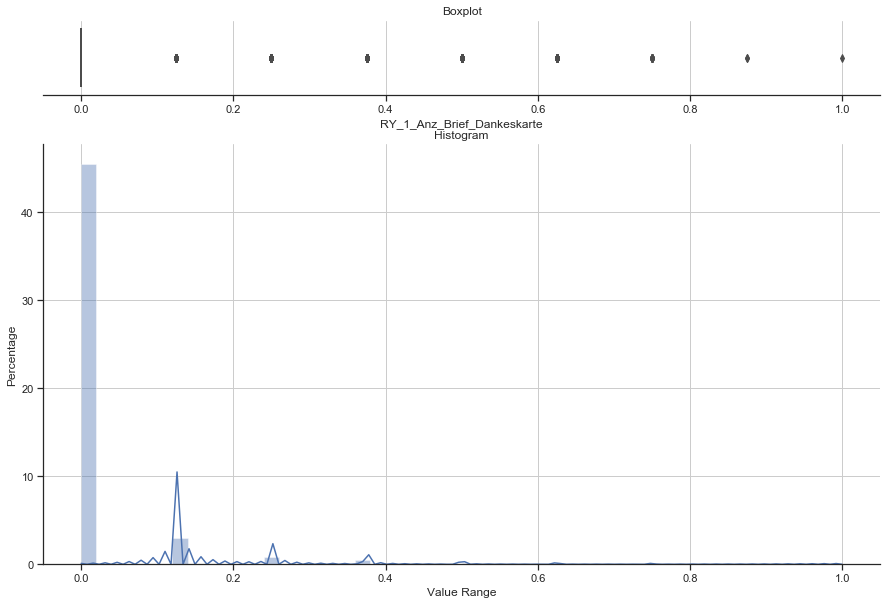

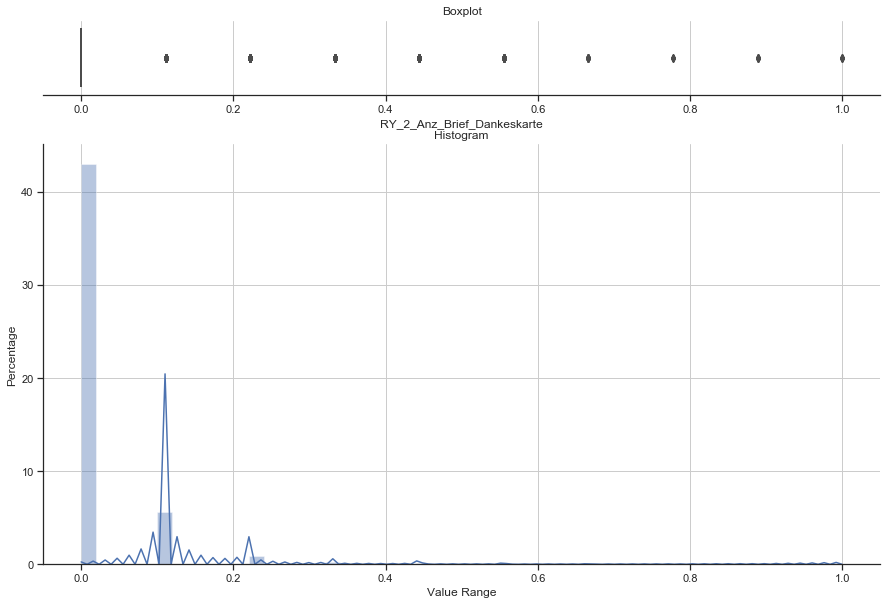

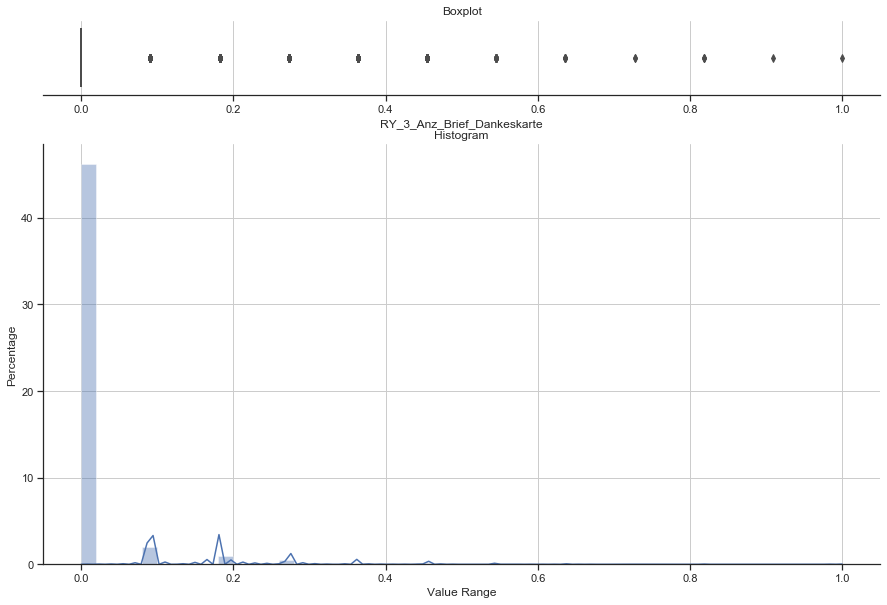

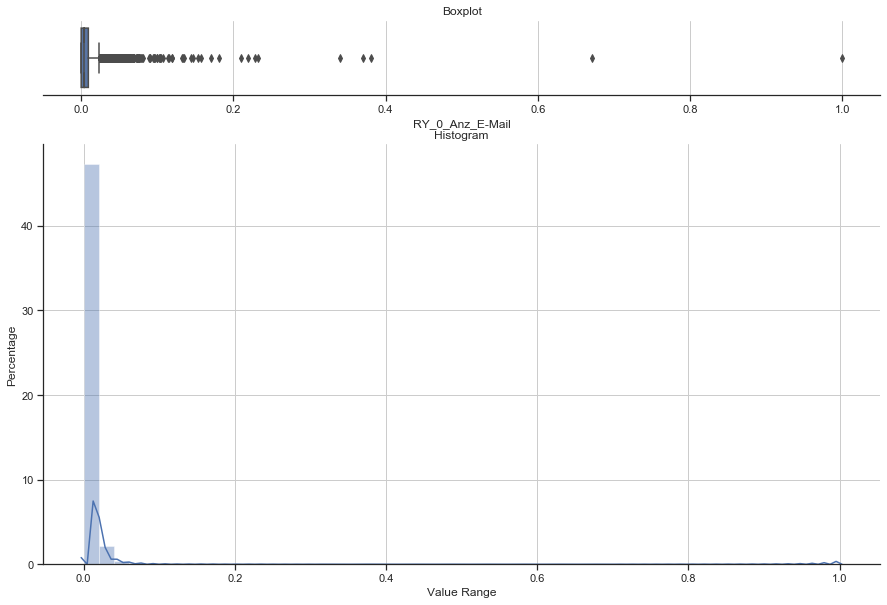

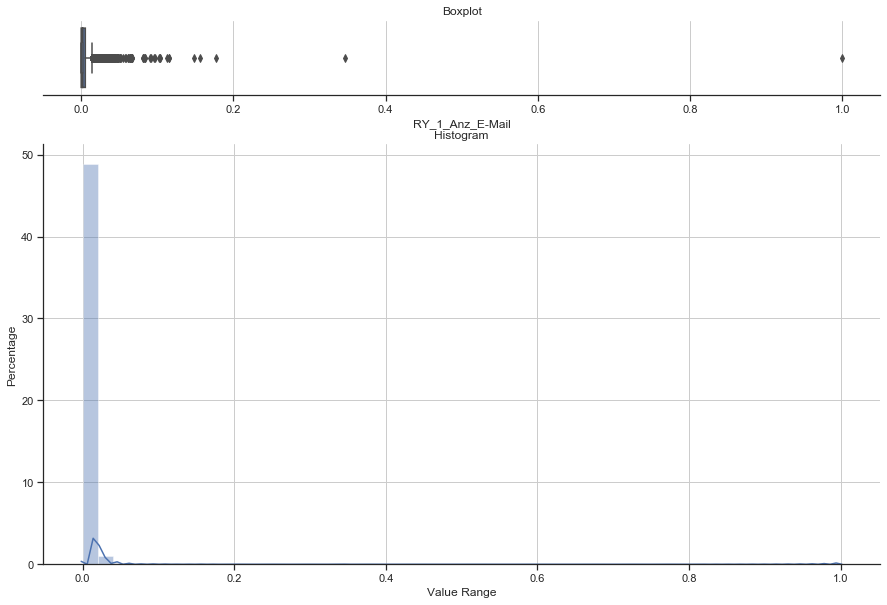

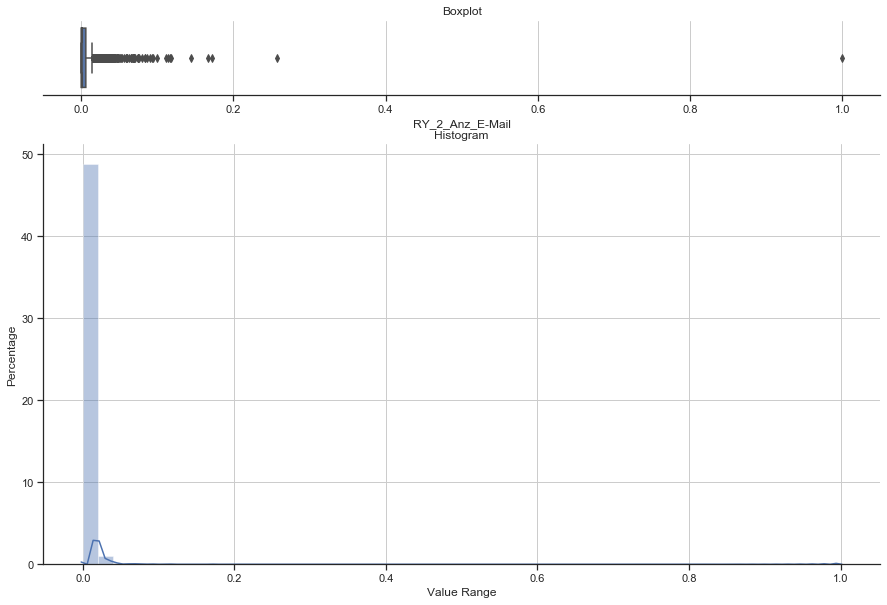

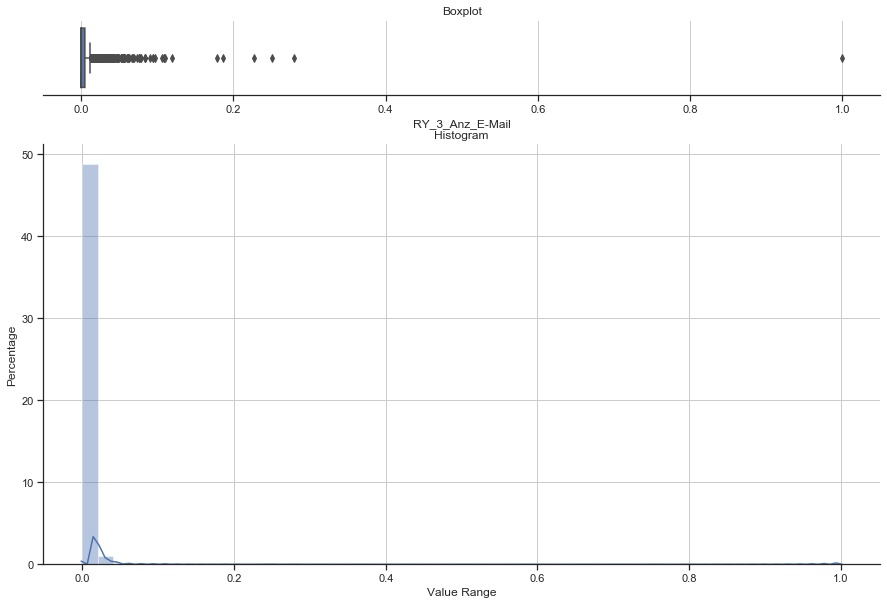

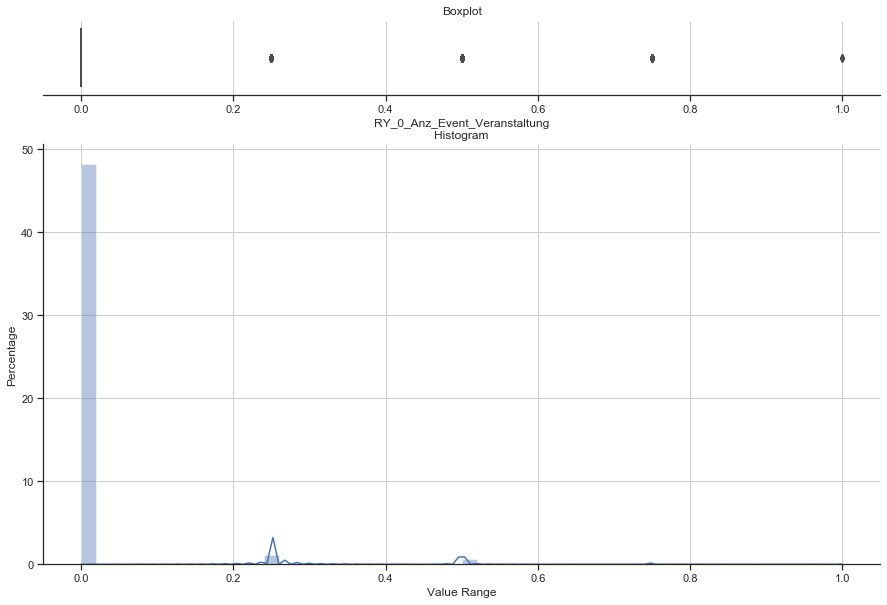

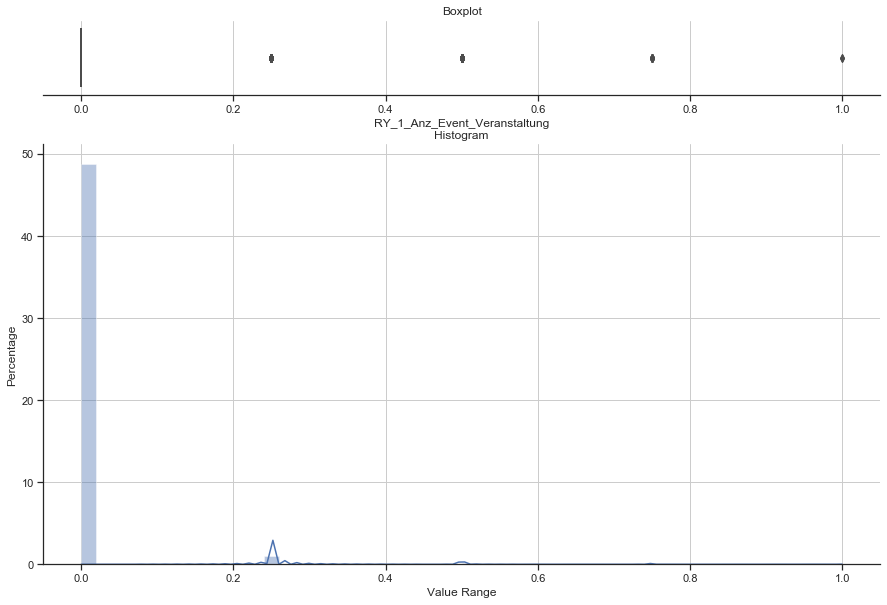

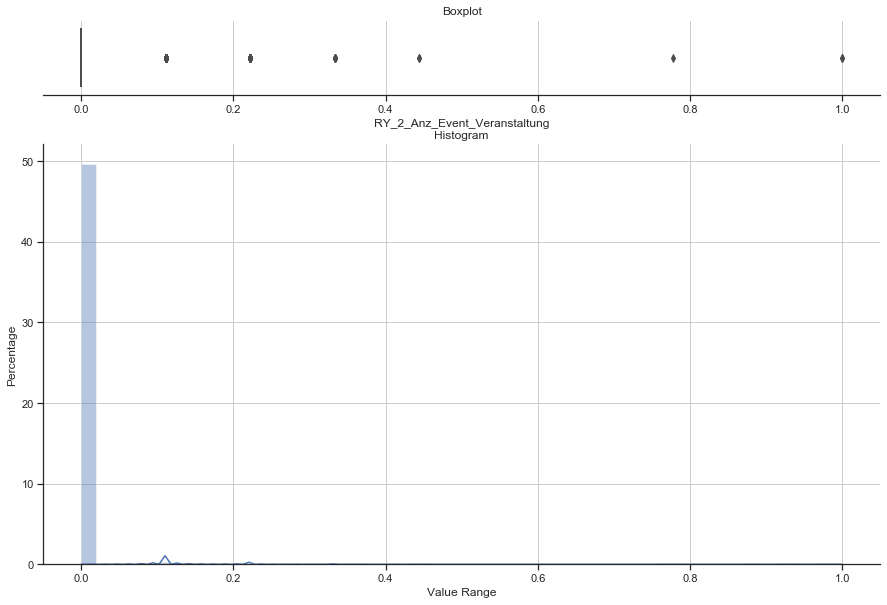

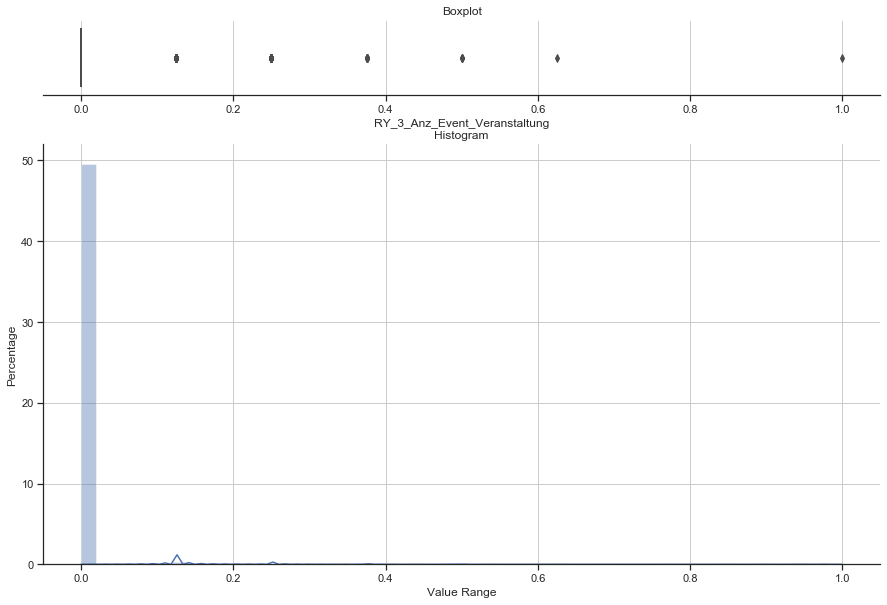

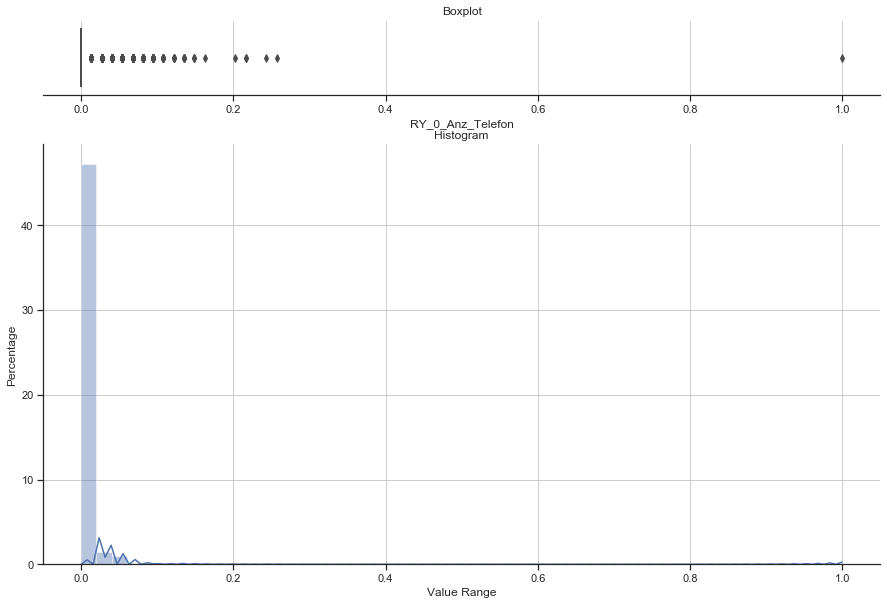

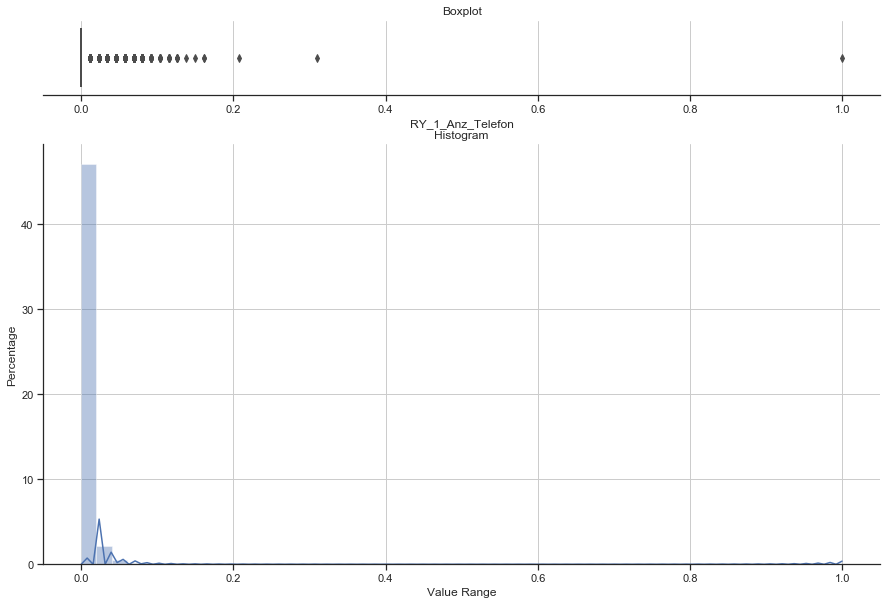

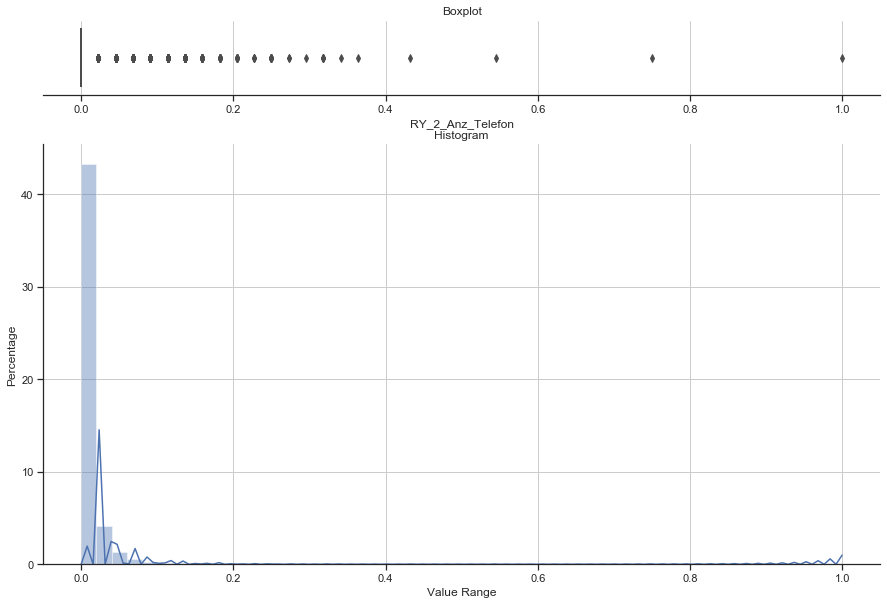

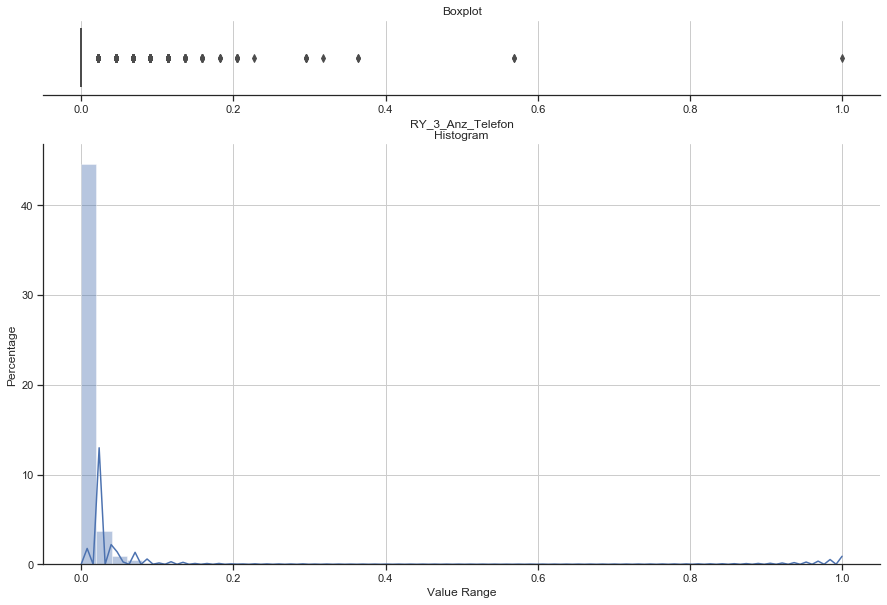

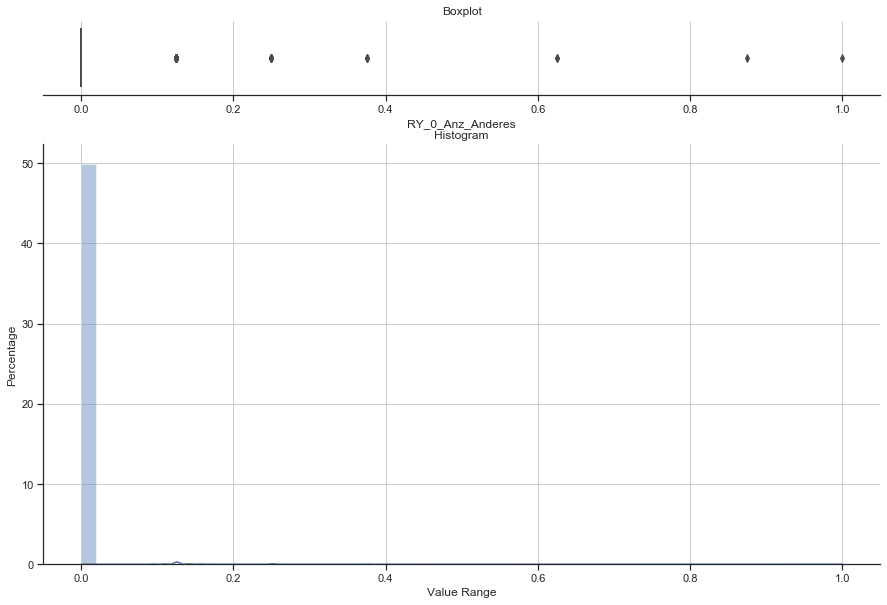

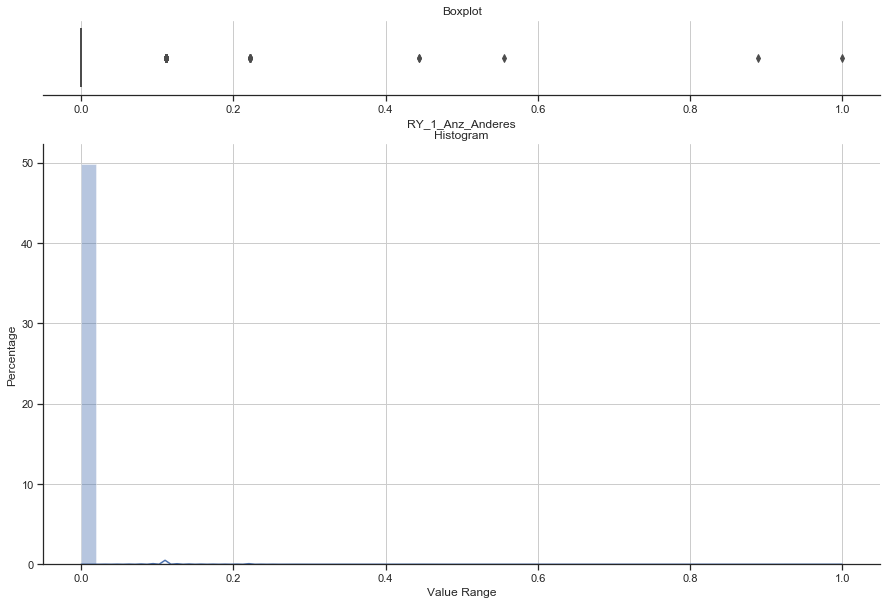

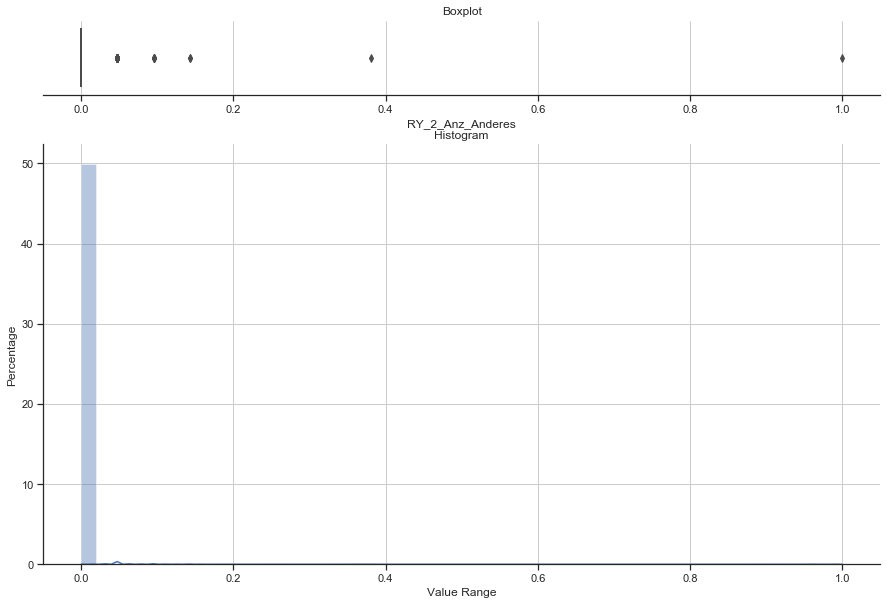

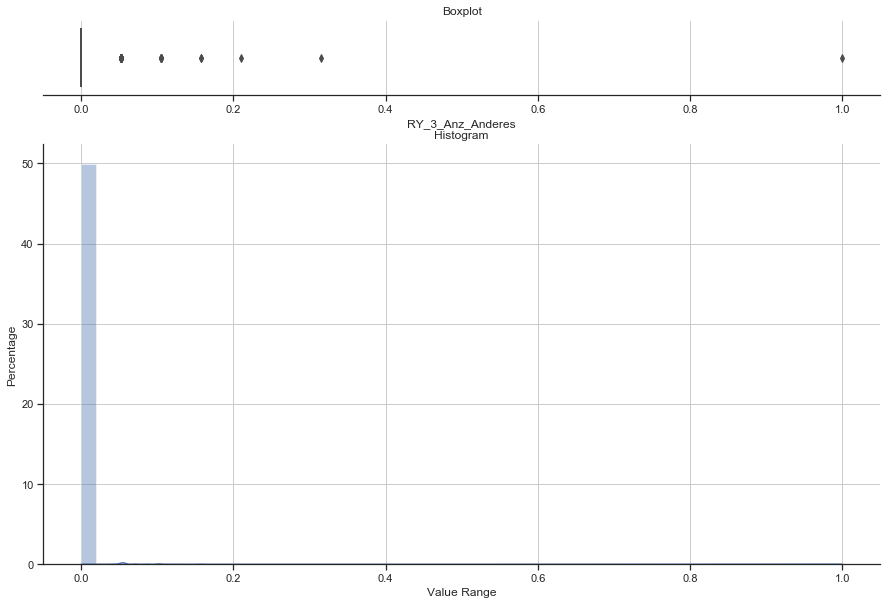

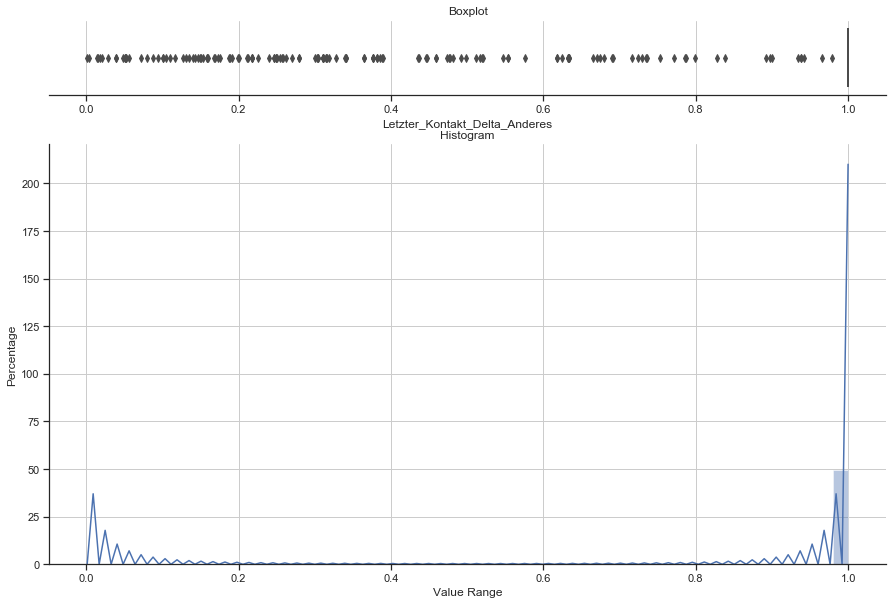

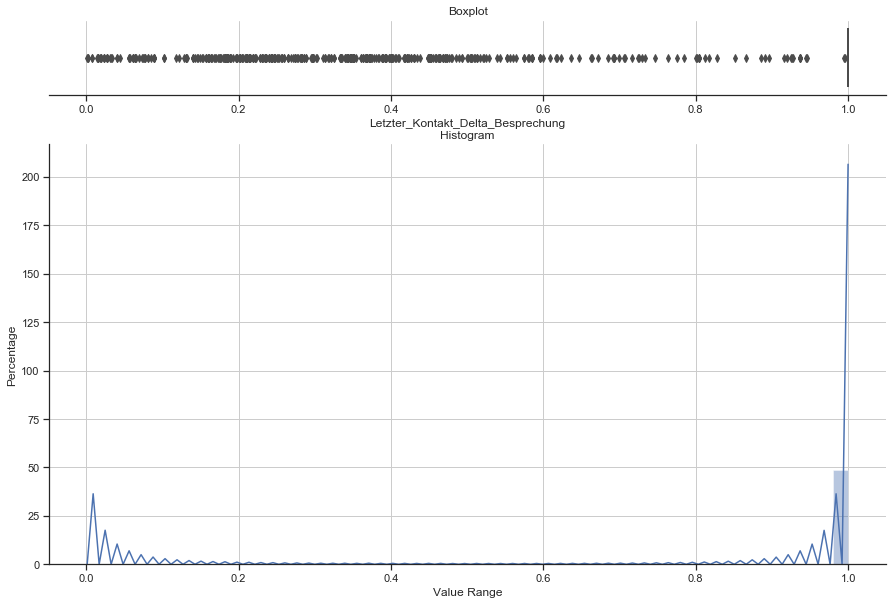

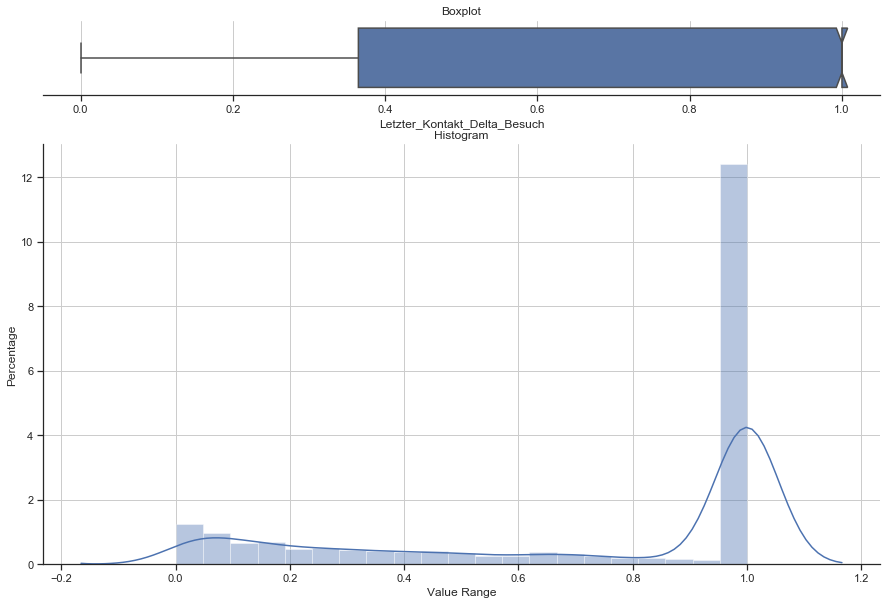

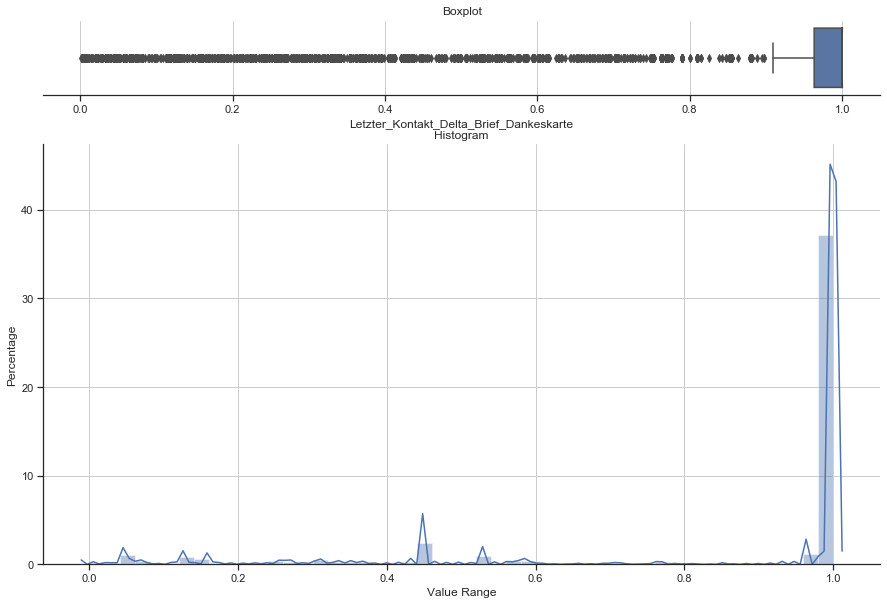

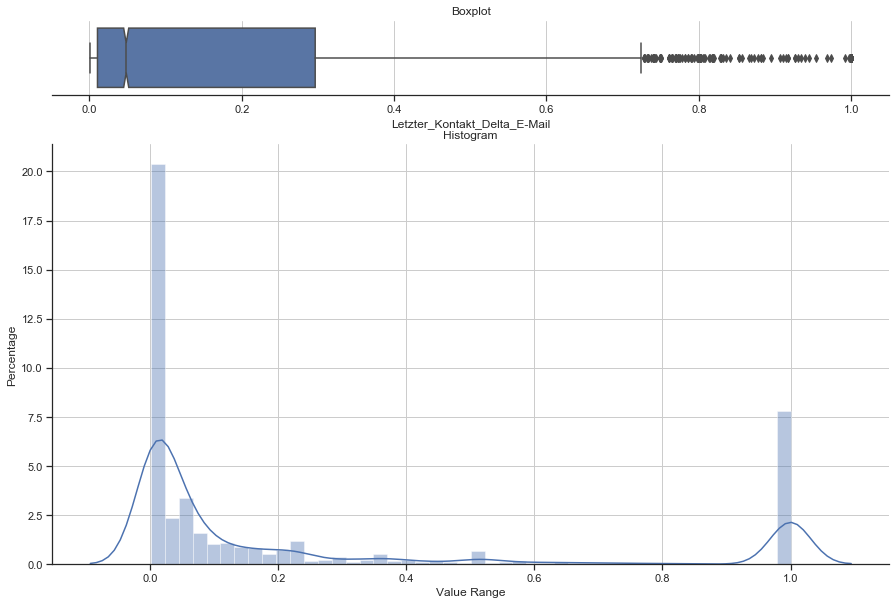

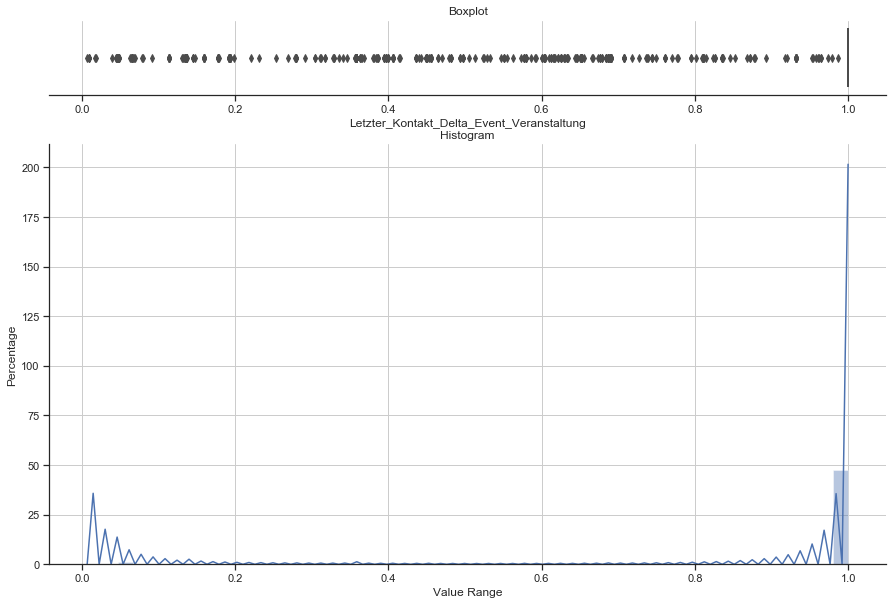

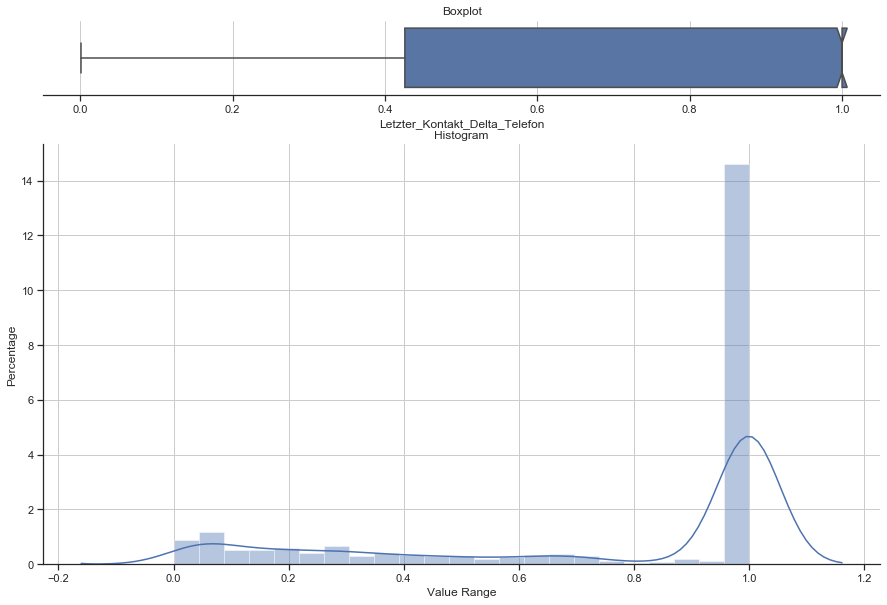

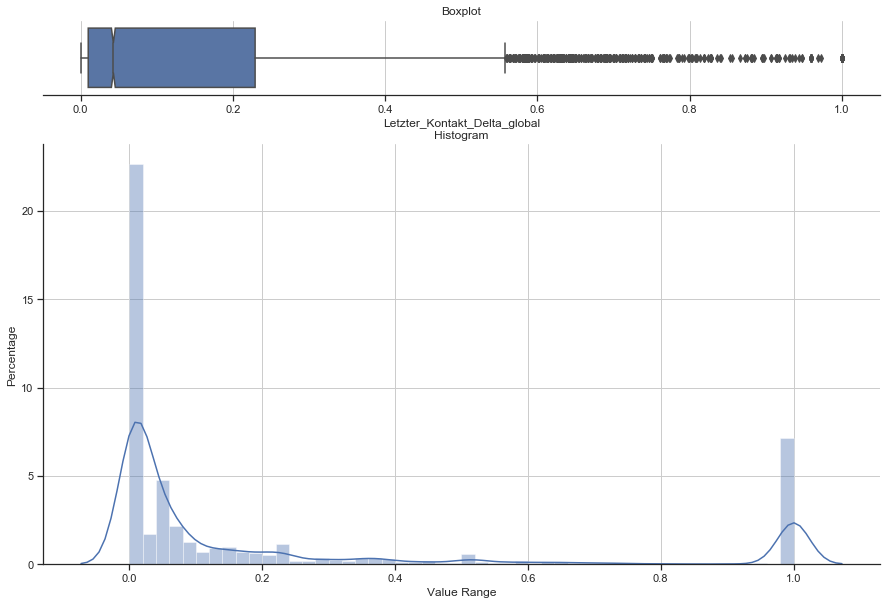

In [20]:
for x in feature_colnames_crm:
    boxplot_histogram(training_all.loc[:,x])

In [21]:
#desc_col(__training_all__).sort_values("NULLS",ascending=False).head(10)

In [22]:
#desc_col(__scoring_all__).sort_values("NULLS",ascending=False).head(10)

In [23]:
print(training_all.shape)
print(scoring_all.shape)

(18059, 345)
(18122, 345)


# Modeling

## Define Columns: Features versus Targets

In [24]:
from itertools import compress
features = feature_colnames_bd + feature_colnames_dates + feature_colnames_branchen + feature_colnames_crm
#feature_columns = list(compress(features,["Target" not in s for s in features]))

feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

#target_columns  = list(compress(training_all.columns,["Target" in s for s in training_all.columns]))

In [25]:
print(len(feature_columns))
print(target_columns)

338
214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_27
217    Target_Sum_Res_RY_0_KW_27
dtype: object


In [26]:
#["Target" not in s for s in features]
#features
#display(feature_columns)

## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [27]:
df_features = training_all.loc[:,feature_columns].to_numpy()
df_target   = training_all.loc[:, "Target_Res_flg"].to_numpy()

df_scoring_features = scoring_all.loc[:,feature_columns].to_numpy()

In [28]:
print(df_features.shape)
print(df_target.shape)

(18059, 338)
(18059,)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)

In [30]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("\ndf_scoring_features", df_scoring_features.shape)

Shape:
X_train: (13544, 338)
y_train: (13544,)
X_test: (4515, 338)
y_test: (4515,)

df_scoring_features (18122, 338)


In [31]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))


y_train:
0
False    13334
True       210
Name: 0, dtype: int64
DescribeResult(nobs=13544, minmax=(False, True), mean=0.015505020673360898, variance=0.015265742129409593, skewness=7.842894064551524, kurtosis=59.51098730777753)

y_test:
0
False    4452
True       63
Name: 0, dtype: int64
DescribeResult(nobs=4515, minmax=(False, True), mean=0.013953488372093023, variance=0.01376183656015909, skewness=8.287389070754609, kurtosis=66.68081761006293)


## Balance Training Dataset

In [32]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [33]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    13334
True     13334
Name: 0, dtype: int64
DescribeResult(nobs=26668, minmax=(False, True), mean=0.5, variance=0.25000937488281394, skewness=0.0, kurtosis=-2.0)


## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [34]:
#from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif
from itertools import compress

In [35]:
%%time
#Wall time: 54 s

# use f_classif (the default) and SelectPercentile to select 50% of features
"""
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=100)
"""
select = SelectKBest(score_func=mutual_info_classif,
            k=150 # How many features? (currently 219 is max)
            )
select.fit(X_train_balanced, y_train_balanced)

mask = select.get_support() # boolean array.

Wall time: 57.2 s


In [36]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (26668, 338)
X_train_balanced[:,mask].shape: (26668, 150)


In [37]:
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [38]:
print("X_scoring:",X_scoring.shape)

X_scoring: (18122, 150)


## Model Training

### Logistic Regression (base model)

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=1000 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C1000.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C1000.score(X_test, y_test)))

Training set score: 0.818
Test set score: 0.802
Wall time: 38.3 s


In [41]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=0.001 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C0001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C0001.score(X_test, y_test)))

Training set score: 0.722
Test set score: 0.715
Wall time: 541 ms


#### Plot Coefficients

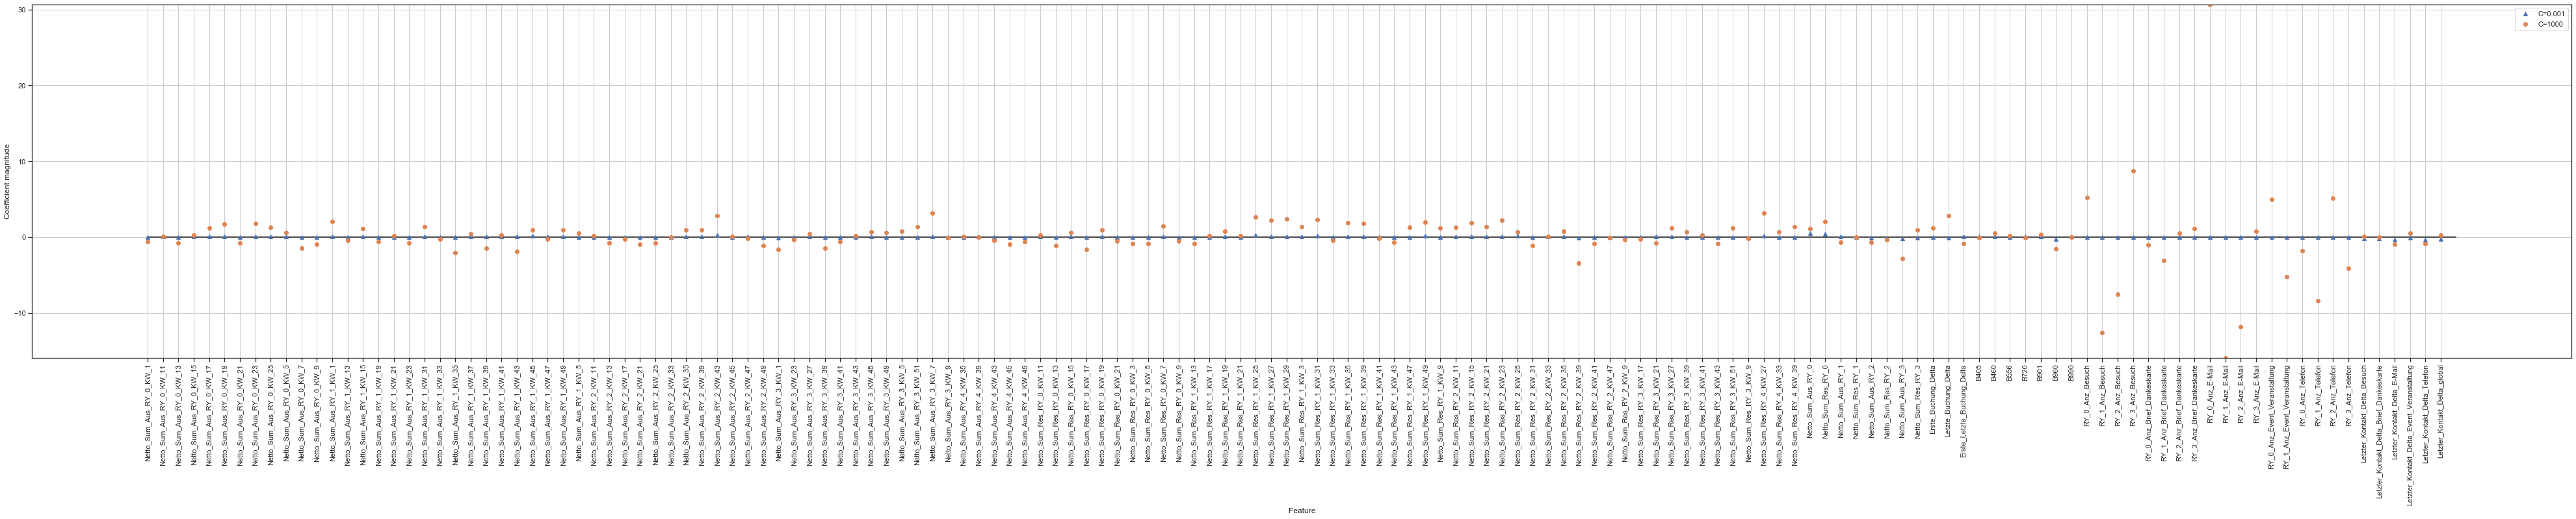

In [42]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_C0001.coef_.T, '^', label="C=0.001")
plt.plot(logreg_C1000.coef_.T,    'o', label="C=1000")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

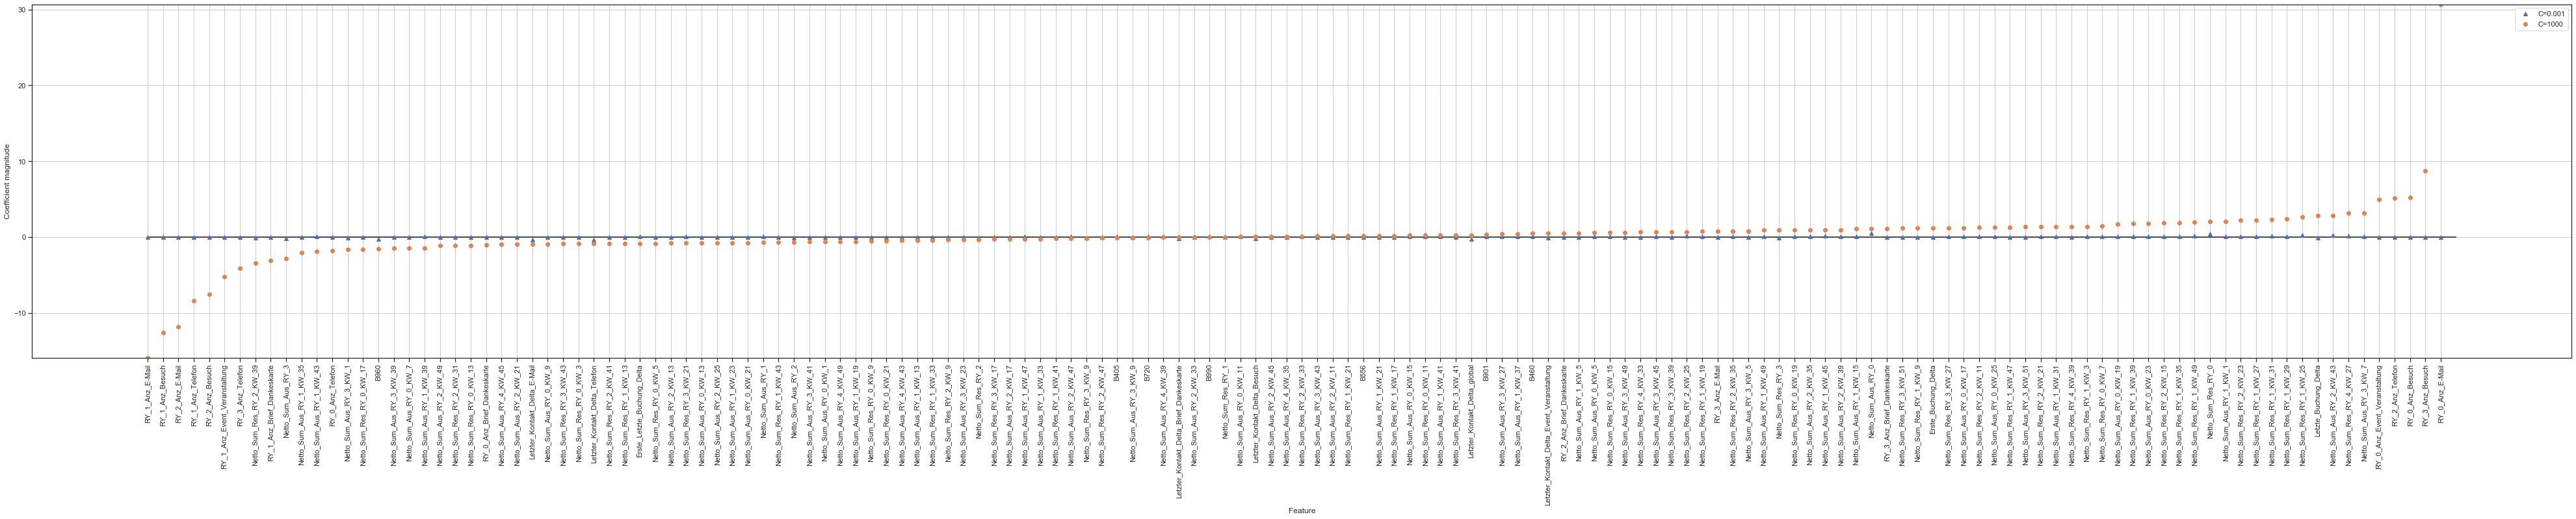

In [43]:
test_df = pd.DataFrame(data={'feature': pd.Series(feature_columns), 
                             'C1000': list(logreg_C1000.coef_.T),
                            'C0001': list(logreg_C0001.coef_.T)})
test_df = test_df.sort_values(by=['C1000']).reset_index()

# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(test_df.loc[:,'C0001'], '^', label="C=0.001")
plt.plot(test_df.loc[:,'C1000'], 'o', label="C=1000")
plt.xticks(range(len(feature_columns)), test_df.loc[:,'feature'], rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Model Training: Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
%%time 
# Wall time: 13min
forest_01 = RandomForestClassifier(n_estimators=5*10**3,
                                max_depth=10,
                                criterion='gini',  #criterion='gini',
                                random_state=42,
                                n_jobs=-1)
forest_01.fit(X_train_balanced, y_train_balanced)
#forest_01.fit(X_train, y_train)

#forest_01.fit(X_train, y_train)

Wall time: 25.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
%%time
# %% Validate Accuracy
print("Accuracy on balanced training set: {:.3f}".format(forest_01.score(X_train_balanced,y_train_balanced)))
print("Accuracy on unbalanced training set: {:.3f}".format(forest_01.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(forest_01.score(X_test,     y_test)))

Accuracy on balanced training set: 0.988
Accuracy on unbalanced training set: 0.988
Accuracy on test set: 0.974
Wall time: 5.27 s


In [47]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

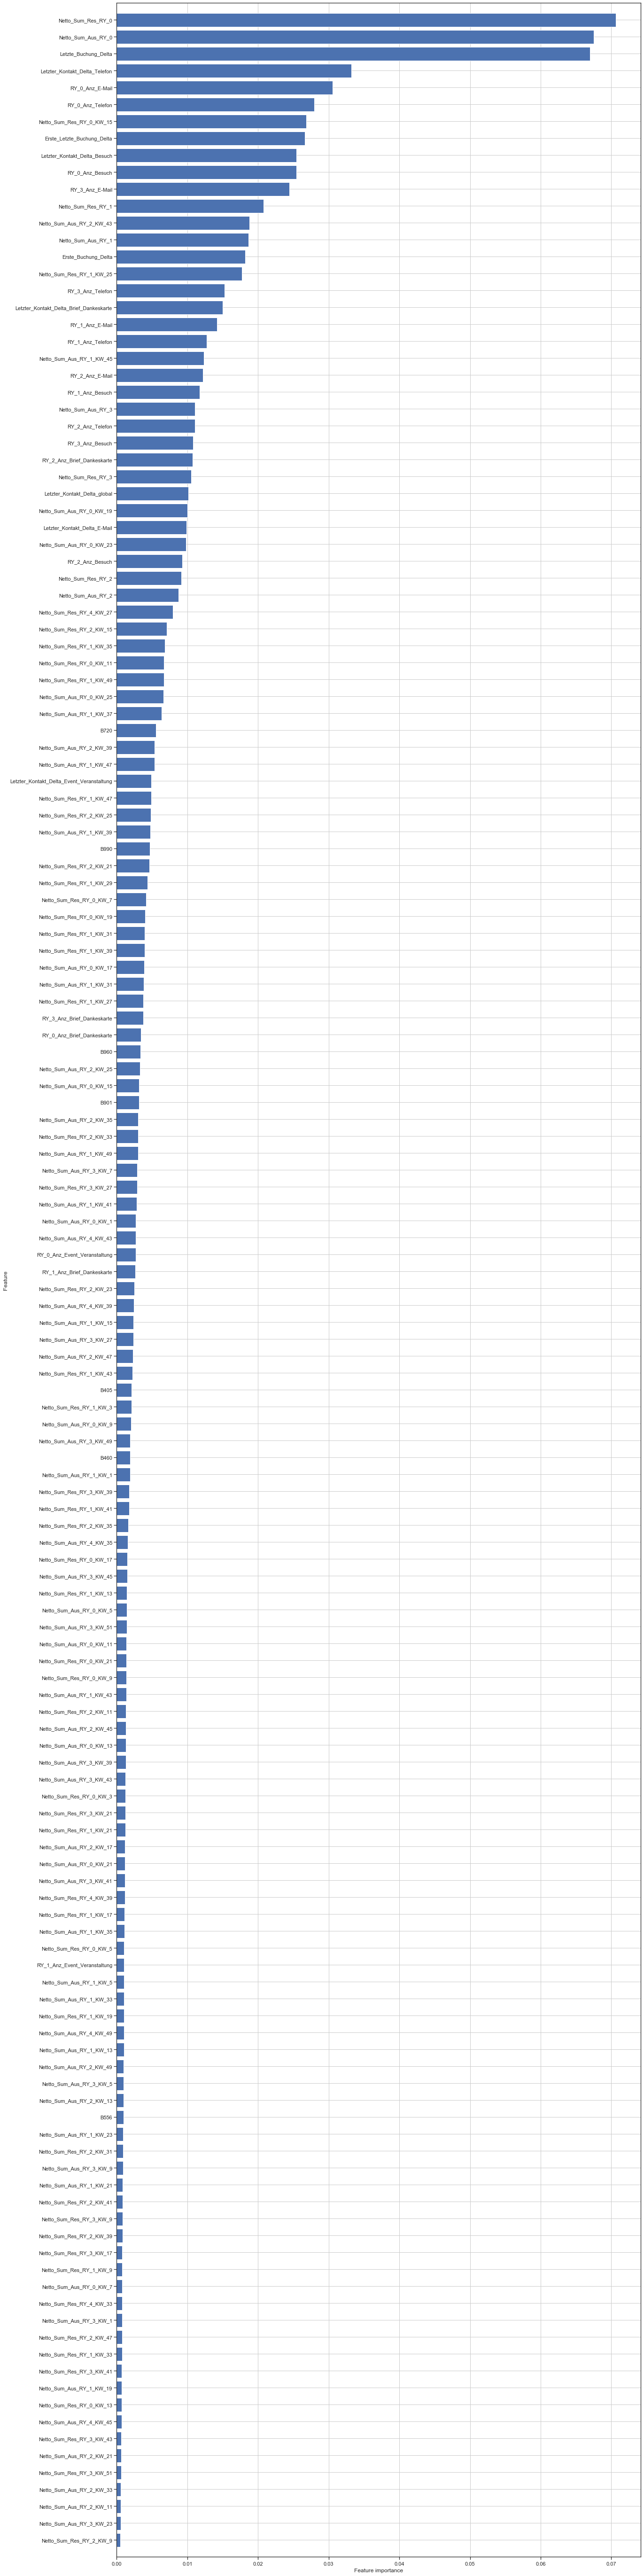

In [48]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01          = forest_01.predict(X_test)
    pred_logreg_C0001       = logreg_C0001.predict(X_test)
    pred_logreg_C1000       = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001       = confusion_matrix(y_test, pred_logreg_C0001)
    df_confusion_logreg_C0001    = pd.DataFrame(confusion_logreg_C0001, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_logreg_C1000       = confusion_matrix(y_test, pred_logreg_C1000)
    df_confusion_logreg_C1000    = pd.DataFrame(confusion_logreg_C1000, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_forest_01          = confusion_matrix(y_test, pred_forest_01)
    df_confusion_forest_01       = pd.DataFrame(confusion_forest_01, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

Wall time: 0 ns


In [51]:
confusion_matrices(X_train_balanced,y_train_balanced)

Test set balance:
True     13334
False    13334
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,13222,112
Fact 1,208,13126



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,9552,3782
Fact 1,3632,9702



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,10794,2540
Fact 1,2301,11033


In [52]:
confusion_matrices(X_train,y_train)

Test set balance:
False    13334
True       210
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,13222,112
Fact 1,48,162



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,9552,3782
Fact 1,44,166



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,10794,2540
Fact 1,43,167


In [53]:
confusion_matrices(X_test,y_test)

Test set balance:
False    4452
True       63
dtype: int64

Confusion Matrices:

Random Forest (forest_01):


,Pred 0,Pred 1
Fact 0,4390,62
Fact 1,57,6



Logistic Regression C=0.001:


,Pred 0,Pred 1
Fact 0,3188,1264
Fact 1,21,42



Logistic Regression C=1000:


,Pred 0,Pred 1
Fact 0,3590,862
Fact 1,30,33


1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [54]:
from sklearn.metrics import classification_report

In [55]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(classification_report(y_test,
                            pred_logreg_C0001,
                            target_names=["not booking = 0", "booking = 1"]))

print("Logistic Regression C=1000:")
print(classification_report(y_test,
                            pred_logreg_C1000,
                            target_names=["not booking = 0", "booking = 1"]))

print("Random Forest:")
print(classification_report(y_test,
                            pred_forest_01,
                            target_names=["not booking = 0", "booking = 1"]))



Logistic Regression C=0.001:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.72      0.83      4452
    booking = 1       0.03      0.67      0.06        63

       accuracy                           0.72      4515
      macro avg       0.51      0.69      0.45      4515
   weighted avg       0.98      0.72      0.82      4515

Logistic Regression C=1000:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.81      0.89      4452
    booking = 1       0.04      0.52      0.07        63

       accuracy                           0.80      4515
      macro avg       0.51      0.67      0.48      4515
   weighted avg       0.98      0.80      0.88      4515

Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.99      0.99      0.99      4452
    booking = 1       0.09      0.10      0.09        63

       accuracy                           0.97      4515
      

## Precision-Recall Curve

In [56]:
logreg_C1000.predict_proba(X_test)[:,1]

array([0.192794  , 0.05560813, 0.12366625, ..., 0.54049879, 0.10728275,
       0.2372762 ])

In [57]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01, recall_forest_01, thresholds_forest_01, precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001,precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    # LogReg C=0.001
    precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001 = precision_recall_curve(
        y_test, 
        logreg_C0001.predict_proba(X_test)[:,1])
    
    # LogReg C=1000
    precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 = precision_recall_curve(
        y_test, 
        logreg_C1000.predict_proba(X_test)[:,1])
    
    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest_01, recall_forest_01, thresholds_forest_01 = precision_recall_curve(
        y_test,
        forest_01.predict_proba(X_test)[:, 1])
    
    

In [58]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name,dot):
        optimum_idx = pd.Series.idxmin(np.power(1-pd.Series(precision_forest_01),2)+np.power(1-pd.Series(recall_forest_01),2))
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize=10,
                     label=f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle="none",
                     c='k',
                     mew=2)

    optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name="forest_01",dot='o')
    optimum_point(precision_logreg_C0001,recall_logreg_C0001,thresholds_logreg_C0001,name="logreg_C0001",dot='x')
    optimum_point(precision_logreg_C1000,recall_logreg_C1000,thresholds_logreg_C1000,name="logreg_C1000",dot='+')

    plt.plot(precision_logreg_C0001, recall_logreg_C0001, label="Logistic Regression, C=0.001")
    plt.plot(precision_logreg_C1000, recall_logreg_C1000, label="Logistic Regression, C=1000")
    plt.plot(precision_forest_01, recall_forest_01, label="Random Forest")

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

Wall time: 0 ns


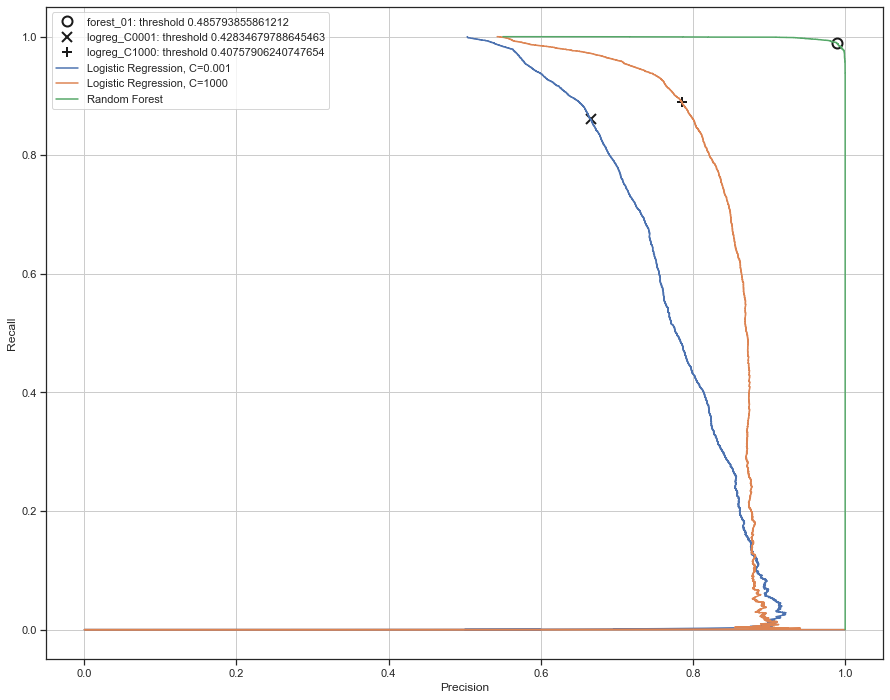

In [59]:
prec_rec_curve(X_train_balanced,y_train_balanced)

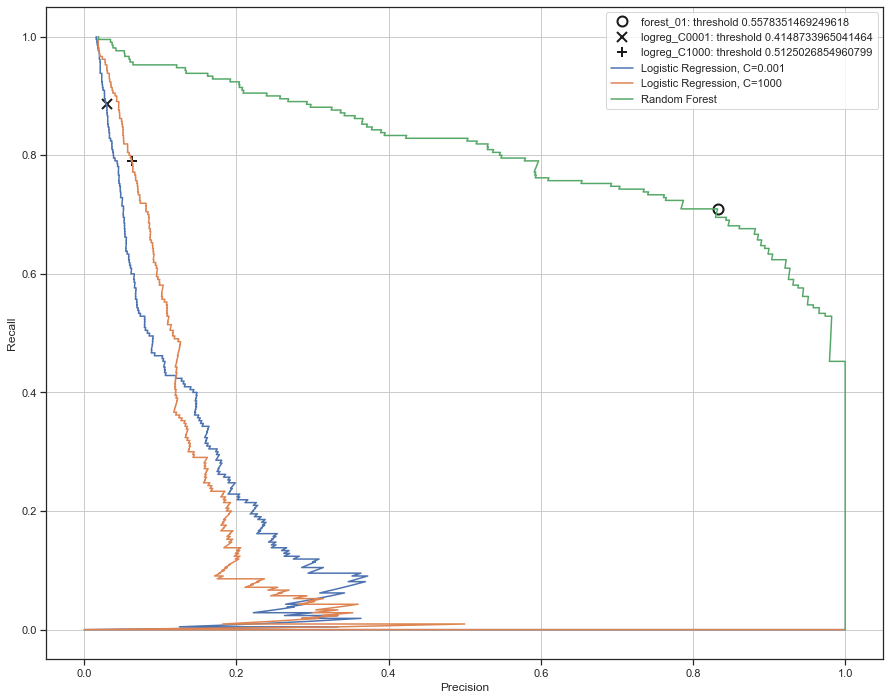

In [60]:
prec_rec_curve(X_train,y_train)

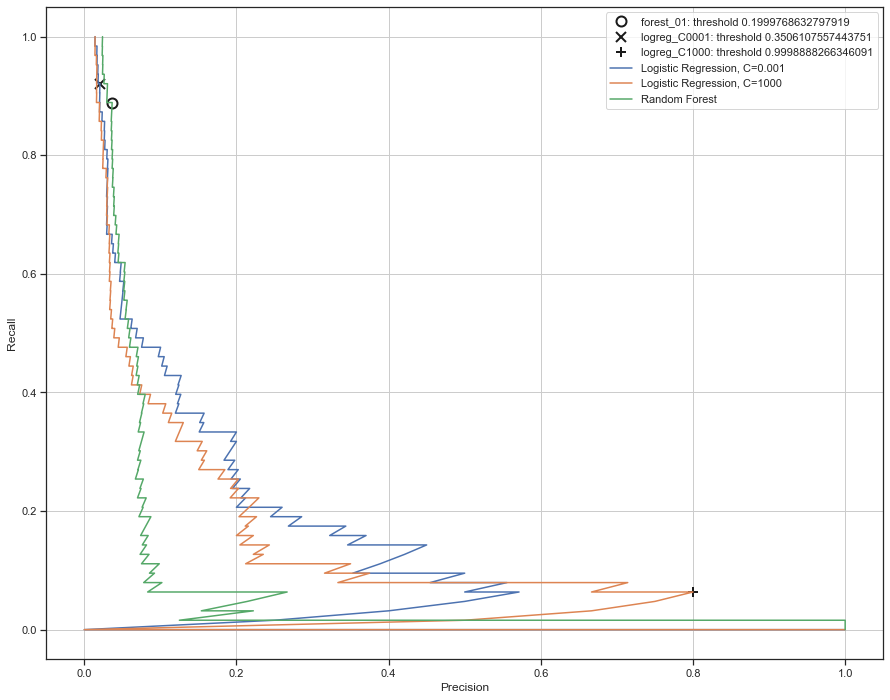

In [61]:
prec_rec_curve(X_test,y_test)

In [62]:
#boxplot_histogram(thresholds_logreg_C0001)

In [63]:
%%time
#Wall time: 19.7 s

from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_logreg_C0001 = average_precision_score(y_test,
                                               logreg_C0001.predict_proba(X_test)[:, 1])

avg_precision_logreg_C1000 = average_precision_score(y_test,
                                               logreg_C1000.predict_proba(X_test)[:, 1])

avg_precision_forest_01 = average_precision_score(y_test,
                                               forest_01.predict_proba(X_test)[:, 1])


print("Average Precision of LogReg C=0.001: {:.3f}".format(avg_precision_logreg_C0001))
print("Average Precision of LogReg C=1000:  {:.3f}".format(avg_precision_logreg_C1000))
print("Average Precision of forest_01:      {:.3f}".format(avg_precision_forest_01))

Average Precision of LogReg C=0.001: 0.146
Average Precision of LogReg C=1000:  0.137
Average Precision of forest_01:      0.081
Wall time: 1.42 s


## Receiver Operating Characteristics (ROC) and AUC


In [64]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001, fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000, fpr_forest_01, tpr_forest_01, thresholds_forest_01
    fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001 = roc_curve(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000 = roc_curve(y_test, logreg_C1000.predict_proba(X_test)[:, 1])
    fpr_forest_01, tpr_forest_01, thresholds_forest_01 = roc_curve(y_test, forest_01.predict_proba(X_test)[:, 1])

    def threshold_dot_50perc(fpr_forest_01,tpr_forest_01,thresholds_forest_01,name,dot):

        close_default_index_forest_01 = pd.Series.idxmin(np.power(1-pd.Series(tpr_forest_01),2)+np.power(pd.Series(fpr_forest_01),2))
        return plt.plot(fpr_forest_01[close_default_index_forest_01], tpr_forest_01[close_default_index_forest_01],
                 dot,
                 markersize=10,
                 label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
                 fillstyle="none",
                 c='k',
                 mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,fpr_forest_01, linestyle='dotted', label="base line")

    plt.plot(fpr_logreg_C0001, tpr_logreg_C0001, label="logreg_C0001")
    plt.plot(fpr_logreg_C1000, tpr_logreg_C1000, label="logreg_C1000")
    plt.plot(fpr_forest_01,    tpr_forest_01,    label="forest_01")


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,tpr_forest_01,     thresholds_forest_01,'forest_01',dot='^')
    threshold_dot_50perc(fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001,'logreg_C0001',dot='x')
    threshold_dot_50perc(fpr_logreg_C1000,tpr_logreg_C1000,thresholds_logreg_C1000,'logreg_C1000',dot='+')

    plt.legend(loc=4)
    plt.show()

Wall time: 0 ns


In [65]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc    = roc_auc_score(y_test,    forest_01.predict_proba(X_test)[:, 1])
    logreg_C0001_auc = roc_auc_score(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    logreg_C1000_auc = roc_auc_score(y_test, logreg_C1000.predict_proba(X_test)[:, 1])


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

Wall time: 0 ns


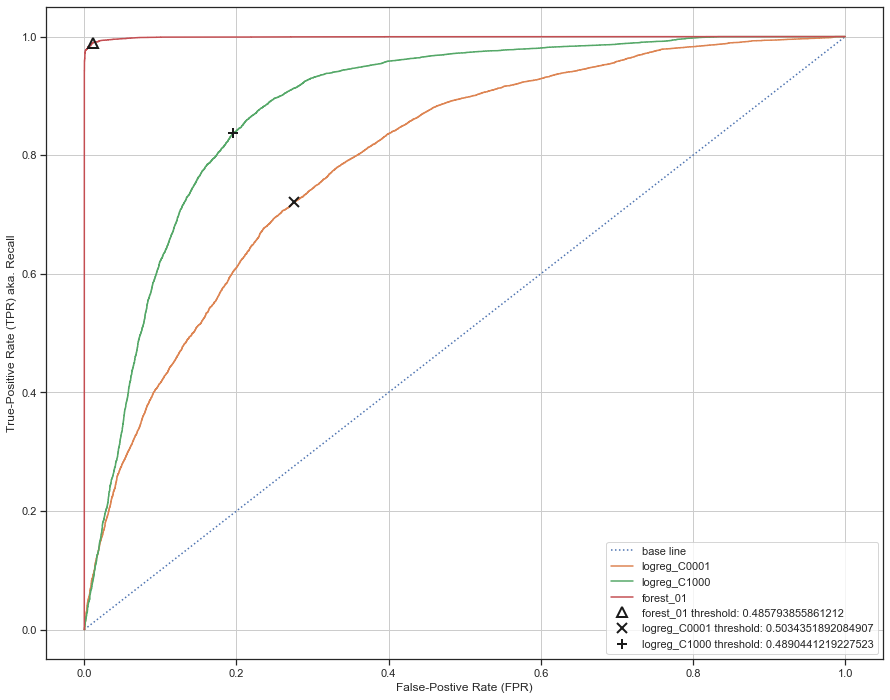

AUC for forest_01:    0.999
AUC for logreg_C0001: 0.794
AUC for logreg_C1000: 0.884
Wall time: 4.41 s


In [66]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,y_train_balanced)
roc_auc(X_train_balanced,y_train_balanced)

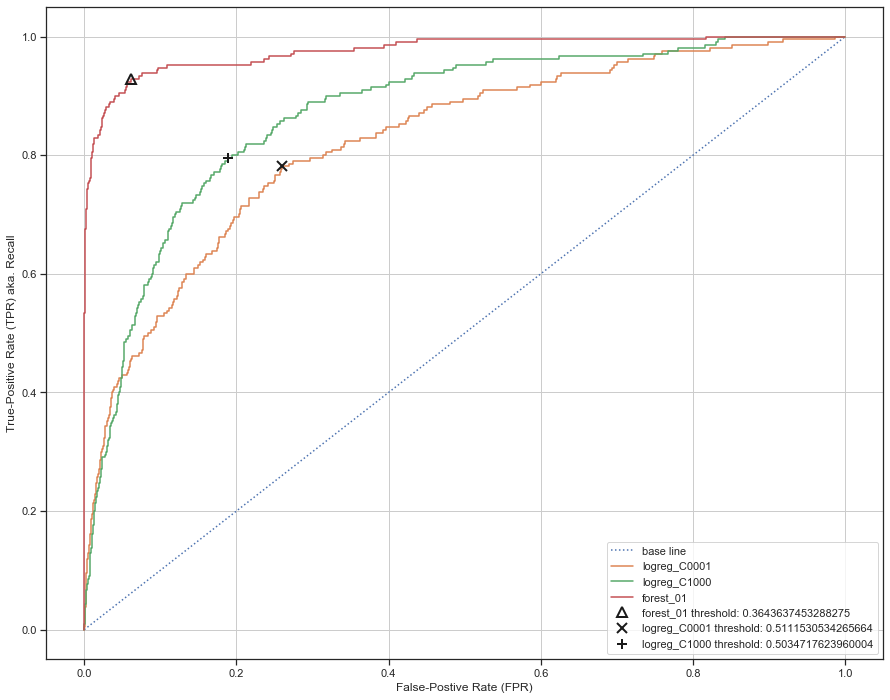

AUC for forest_01:    0.976
AUC for logreg_C0001: 0.823
AUC for logreg_C1000: 0.872
Wall time: 3.56 s


In [67]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,y_train)
roc_auc(X_train,y_train)

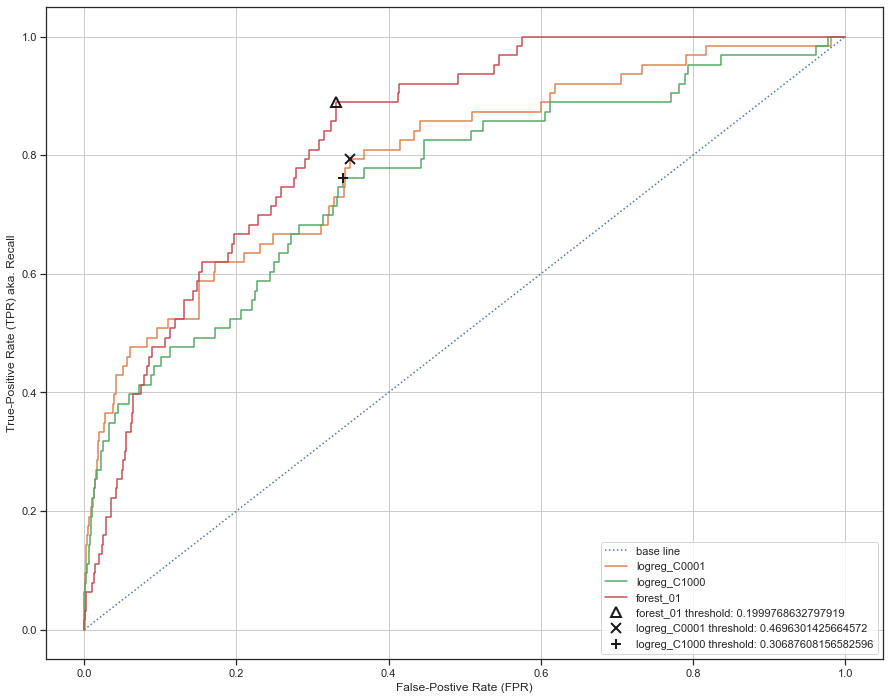

AUC for forest_01:    0.833
AUC for logreg_C0001: 0.791
AUC for logreg_C1000: 0.757
Wall time: 3.03 s


In [68]:
%%time
roc_curve_graph(X_test,y_test)
roc_auc(X_test,y_test)

## Recursive feature elimination with cross-validation

## Shapley values

https://medium.com/@santiagof/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [69]:
scoring_prob     = forest_01.predict_proba(X_scoring)
scoring_prob_df  = pd.DataFrame(scoring_prob, columns=["Prob_0","Prob_1"])
scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [70]:
scoring_all_prob.head()

,Endkunde_NR,Kampagne_Erfass_Datum_min,Kampagne_Erfass_Datum_max,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,Netto_Sum_Aus_RY_0_KW_21,Netto_Sum_Aus_RY_0_KW_23,Netto_Sum_Aus_RY_0_KW_25,Netto_Sum_Aus_RY_0_KW_3,Netto_Sum_Aus_RY_0_KW_5,Netto_Sum_Aus_RY_0_KW_7,Netto_Sum_Aus_RY_0_KW_9,Netto_Sum_Aus_RY_1_KW_1,Netto_Sum_Aus_RY_1_KW_11,Netto_Sum_Aus_RY_1_KW_13,Netto_Sum_Aus_RY_1_KW_15,Netto_Sum_Aus_RY_1_KW_17,Netto_Sum_Aus_RY_1_KW_19,Netto_Sum_Aus_RY_1_KW_21,Netto_Sum_Aus_RY_1_KW_23,Netto_Sum_Aus_RY_1_KW_25,Netto_Sum_Aus_RY_1_KW_27,Netto_Sum_Aus_RY_1_KW_29,Netto_Sum_Aus_RY_1_KW_3,Netto_Sum_Aus_RY_1_KW_31,Netto_Sum_Aus_RY_1_KW_33,Netto_Sum_Aus_RY_1_KW_35,Netto_Sum_Aus_RY_1_KW_37,Netto_Sum_Aus_RY_1_KW_39,Netto_Sum_Aus_RY_1_KW_41,Netto_Sum_Aus_RY_1_KW_43,Netto_Sum_Aus_RY_1_KW_45,Netto_Sum_Aus_RY_1_KW_47,Netto_Sum_Aus_RY_1_KW_49,Netto_Sum_Aus_RY_1_KW_5,Netto_Sum_Aus_RY_1_KW_51,Netto_Sum_Aus_RY_1_KW_7,Netto_Sum_Aus_RY_1_KW_9,Netto_Sum_Aus_RY_2_KW_1,Netto_Sum_Aus_RY_2_KW_11,Netto_Sum_Aus_RY_2_KW_13,Netto_Sum_Aus_RY_2_KW_15,Netto_Sum_Aus_RY_2_KW_17,Netto_Sum_Aus_RY_2_KW_19,Netto_Sum_Aus_RY_2_KW_21,Netto_Sum_Aus_RY_2_KW_23,Netto_Sum_Aus_RY_2_KW_25,Netto_Sum_Aus_RY_2_KW_27,Netto_Sum_Aus_RY_2_KW_29,Netto_Sum_Aus_RY_2_KW_3,Netto_Sum_Aus_RY_2_KW_31,Netto_Sum_Aus_RY_2_KW_33,Netto_Sum_Aus_RY_2_KW_35,Netto_Sum_Aus_RY_2_KW_37,Netto_Sum_Aus_RY_2_KW_39,Netto_Sum_Aus_RY_2_KW_41,Netto_Sum_Aus_RY_2_KW_43,Netto_Sum_Aus_RY_2_KW_45,Netto_Sum_Aus_RY_2_KW_47,Netto_Sum_Aus_RY_2_KW_49,Netto_Sum_Aus_RY_2_KW_5,Netto_Sum_Aus_RY_2_KW_51,Netto_Sum_Aus_RY_2_KW_7,Netto_Sum_Aus_RY_2_KW_9,Netto_Sum_Aus_RY_3_KW_1,Netto_Sum_Aus_RY_3_KW_11,Netto_Sum_Aus_RY_3_KW_13,Netto_Sum_Aus_RY_3_KW_15,Netto_Sum_Aus_RY_3_KW_17,Netto_Sum_Aus_RY_3_KW_19,Netto_Sum_Aus_RY_3_KW_21,Netto_Sum_Aus_RY_3_KW_23,Netto_Sum_Aus_RY_3_KW_25,Netto_Sum_Aus_RY_3_KW_27,Netto_Sum_Aus_RY_3_KW_29,Netto_Sum_Aus_RY_3_KW_3,Netto_Sum_Aus_RY_3_KW_31,Netto_Sum_Aus_RY_3_KW_33,Netto_Sum_Aus_RY_3_KW_35,Netto_Sum_Aus_RY_3_KW_37,Netto_Sum_Aus_RY_3_KW_39,Netto_Sum_Aus_RY_3_KW_41,Netto_Sum_Aus_RY_3_KW_43,Netto_Sum_Aus_RY_3_KW_45,Netto_Sum_Aus_RY_3_KW_47,Netto_Sum_Aus_RY_3_KW_49,Netto_Sum_Aus_RY_3_KW_5,Netto_Sum_Aus_RY_3_KW_51,Netto_Sum_Aus_RY_3_KW_7,Netto_Sum_Aus_RY_3_KW_9,Netto_Sum_Aus_RY_4_KW_27,Netto_Sum_Aus_RY_4_KW_29,Netto_Sum_Aus_RY_4_KW_31,Netto_Sum_Aus_RY_4_KW_33,Netto_Sum_Aus_RY_4_KW_35,Netto_Sum_Aus_RY_4_KW_37,Netto_Sum_Aus_RY_4_KW_39,Netto_Sum_Aus_RY_4_KW_41,Netto_Sum_Aus_RY_4_KW_43,Netto_Sum_Aus_RY_4_KW_45,Netto_Sum_Aus_RY_4_KW_47,Netto_Sum_Aus_RY_4_KW_49,Netto_Sum_Aus_RY_4_KW_51,Netto_Sum_Res_RY_0_KW_1,Netto_Sum_Res_RY_0_KW_11,Netto_Sum_Res_RY_0_KW_13,Netto_Sum_Res_RY_0_KW_15,Netto_Sum_Res_RY_0_KW_17,Netto_Sum_Res_RY_0_KW_19,Netto_Sum_Res_RY_0_KW_21,Netto_Sum_Res_RY_0_KW_23,Netto_Sum_Res_RY_0_KW_25,Netto_Sum_Res_RY_0_KW_3,Netto_Sum_Res_RY_0_KW_5,Netto_Sum_Res_RY_0_KW_7,Netto_Sum_Res_RY_0_KW_9,Netto_Sum_Res_RY_1_KW_1,Netto_Sum_Res_RY_1_KW_11,Netto_Sum_Res_RY_1_KW_13,Netto_Sum_Res_RY_1_KW_15,Netto_Sum_Res_RY_1_KW_17,Netto_Sum_Res_RY_1_KW_19,Netto_Sum_Res_RY_1_KW_21,Netto_Sum_Res_RY_1_KW_23,Netto_Sum_Res_RY_1_KW_25,Netto_Sum_Res_RY_1_KW_27,Netto_Sum_Res_RY_1_KW_29,Netto_Sum_Res_RY_1_KW_3,Netto_Sum_Res_RY_1_KW_31,Netto_Sum_Res_RY_1_KW_33,Netto_Sum_Res_RY_1_KW_35,Netto_Sum_Res_RY_1_KW_37,Netto_Sum_Res_RY_1_KW_39,Netto_Sum_Res_RY_1_KW_41,Netto_Sum_Res_RY_1_KW_43,Netto_Sum_Res_RY_1_KW_45,Netto_Sum_Res_RY_1_KW_47,Netto_Sum_Res_RY_1_KW_49,Netto_Sum_Res_RY_1_KW_5,Netto_Sum_Res_RY_1_KW_51,Netto_Sum_Res_RY_1_KW_7,Netto_Sum_Res_RY_1_KW_9,Netto_Sum_Res_RY_2_KW_1,Netto_Sum_Res_RY_2_KW_11,Netto_Sum_Res_RY_2_KW_13,Netto_Sum_Res_RY_2_KW_15,Netto_Sum_Res_RY_2_KW_17,Netto_Sum_Res_RY_2_KW_19,Netto_Sum_Res_RY_2_KW_21,Netto_Sum_Res_RY_2_KW_23,Netto_Sum_Res_RY_2_KW_25,Netto_Sum_Res_RY_2_KW_27,Netto_Sum_Res_RY_2_KW_29,Netto_Sum_Res_RY_2_KW_3,Netto_Sum_Res_RY_2_KW_31

## Backup for comparision with Rscript

In [71]:
backup_scorings_df =  scoring_all_prob.loc[:,["Endkunde_NR","Prob_1"]]

with project_dir("vkprog\\predictions"):
    store_bin(backup_scorings_df, "20190701_pred_rebuild_without_sales_filter.feather")


12:23:42 [INFO] Started storing binary file
12:23:42 [INFO] Writing to file C:\Users\stc\data\vkprog\predictions\20190701_pred_rebuild_without_sales_filter.feather
12:23:42 [INFO] Written 425.1 KB
12:23:42 [INFO] Finished storing binary file in 0.01s (0.0s CPU)


## Adding additional information for delivery lists ``EK_LIST_2W_KOMPLETT.csv``

In [ ]:
from pa_lib.file import load_bin

In [ ]:
ek_info = load_bin("vkprog\\ek_info.feather")

In [ ]:
ek_list_raw = pd.merge(scoring_all_prob,ek_info,on="Endkunde_NR", how="left")

In [ ]:
ek_list_raw.shape

In [ ]:
# Check _col_selection_ in file "vp2xlsx.py". It's the only one that actually counts! Compare with R-code to figure out the meaning.

net_columns = [col for col in ek_info.columns if col.startswith("Net_")]

col_row_filter =([
    "Insolvenz",
    "Last_Res_Date",
    "Last_Aus_Date",
    "last_CRM_Ktkt_date",
    "VB_FILTER_VON",
    "VB_FILTER_BIS"
    ])

listing = (
    ["Endkunde_NR",      # Endkunde_NR
     "Endkunde",         # Endkunde
     "EK_HB_Apg_Kurzz",  # HB_APG (based on R-script)
     "Agentur",          # Agentur
     "AG_Hauptbetreuer", # HB_Agentur   
     "PLZ",              # PLZ
     "GEMEINDE"]        # Ort
    
     +net_columns       # Net_2015, Net_2016, Net_2017, Net_2018, Net_2019 
    
     +["letzte_VBs",     # (bd, aggregiert)
       "Letzter_Kontakt", # KZ_letzter_Ktkt (crm)
       "Kanal",           #(crm)
       "Betreff",         #(crm)    
       "Last_Res_Date", # Letzte_Kamp_erfasst
       "Last_Aus_Date", # letzte_Kamp_Beginn
       "VERKAUFS_GEBIETS_CODE", # Verkaufsgebiet
       "VB_VKGEB",      
       "Prob_1"        # prob_KW (from here, good good.)
       ]
    # Needed for row_filter
    + col_row_filter
    )

ek_list = (ek_list_raw
    .loc[:,listing]
    .rename(columns={
        "EK_HB_Apg_Kurzz": "HB_APG",
        "AG_Hauptbetreuer": "HB_Agentur",
        "GEMEINDE": "Ort",
        "Letzter_Kontakt": "letzter_Kontakt",
        "Last_Res_Date": "letzte_Kamp_erfasst",
        "Last_Aus_Date":"letzte_Kamp_Beginn",
        "VERKAUFS_GEBIETS_CODE": "Verkaufsgebiet",
        "VB_VKGEB": "VB_VK_Geb",
        "Prob_1": "prob_KW"
    })       
    )

ek_list.shape

In [ ]:
ek_list.sample(10)

## Pauschale Filterkriterien (muss rüber ins vp2xlsx.py)

In [ ]:
net_columns = [col for col in ek_info.columns if col.startswith("Net_")] # Net_2015, ..., Net_2019
pauschale_filter = (
    # Insolvenz:
    (ek_info.loc[:,"Insolvenz"] 
         != True
    ) &
    
    # kuerzlich_gebucht (in den letzten 2 Monaten erfasste Kampagnen):
    (ek_info.loc[:,"Last_Res_Date"] 
        < pd.Timestamp.now() - pd.DateOffset(months=2)
    ) &
    
    # kuerzlich_im_aushang (Aushangbeginn vor 1 Monat oder später):
    (ek_info.loc[:,"Last_Aus_Date"] 
        < pd.Timestamp.now() - pd.DateOffset(months=1)
    ) &
    
    # keine Kleinkunden (Ueber die letzten 4 Jahre nie mehr als 3'000 pro Jahr):
    (ek_info.loc[:,net_columns].max(axis=1).fillna(0) 
        > 3000
    ) &
    
    # keine Neukunden (Alle, die erst im aktuellen Jahr Umsatz hatten):
    ((ek_info.loc[:,sorted(net_columns, reverse=True)[1:]]
             .max(axis=1)
             .fillna(0))
        > 0
    ) &
    
    # Umsatz_erreicht (80% Netto-Umsatz gem. Vorjahr erreicht) 
    ((ek_info.loc[:,sorted(net_columns, reverse=True)[0]]
             .fillna(0))
         <= 0.8*(ek_info.loc[:,sorted(net_columns, reverse=True)[1]]
                        .fillna(0))
    ) &
    
    # kuerzlich_im_kontakt (keine Kunden, mit CRM-Kontakt in den letzten 4 Wochen)
    (ek_info.loc[:,"last_CRM_Ktkt_date"].fillna(pd.Timestamp.now() - pd.DateOffset(years=100)) 
        < pd.Timestamp.now() - pd.DateOffset(months=1)
    ) &
    
    # VB_FILTER_AKTIV (in CRM ist eine gültige Sperre für Kunden erfasst)
     ~(# We define the evil ones, and take the boolean opposite:
    
         # Both entries exist: Customer is right now within "Sperre"
        ((ek_info.loc[:,"VB_FILTER_VON"] < pd.Timestamp.now()) &
         (pd.Timestamp.now() <= ek_info.loc[:,"VB_FILTER_BIS"]))

        |# No end date, but begin date exists: 
        ((ek_info.loc[:,"VB_FILTER_VON"] < pd.Timestamp.now()) &
         (ek_info.loc[:,"VB_FILTER_BIS"].isna() ))

        |# No begin date, but end date exists:
        (ek_info.loc[:,"VB_FILTER_VON"].isna() & 
         (ek_info.loc[:,"VB_FILTER_BIS"] <= pd.Timestamp.now() )) 
      )
    
    )

In [ ]:
ek_list_pauschale_filter = ek_list.loc[pauschale_filter,:]
ek_list_pauschale_filter.shape

In [ ]:
ek_list_pauschale_filter.sample(20)

## Cutoff: Selecting the customers with the highest chances for a sale

In [ ]:
print("Reality Check: \nThat's how many last year made reservations in these calendar weeks:")
training_all.groupby("Target_Res_flg").agg({"Endkunde_NR": "count"})

Check the distribution to define a reasonable cut-off:

In [ ]:
boxplot_histogram(ek_list_pauschale_filter.loc[:,"prob_KW"])
ek_list_pauschale_filter.loc[:,"prob_KW"].describe()


In [ ]:
def cutoff_by_quantile(dataframe, quantile=0.25):
    """
    Input: 
        - Dataframe with Probabilities for a reservation
        - Quantile
    
    Output:
        - Subset of initial dataframe cutoff via defined Quantile
    """
    quantile_75      = dataframe.prob_KW.quantile([quantile]).iloc[0]
    filter_col       = (dataframe.loc[:,"prob_KW"] > quantile_75)
    dataframe_cutoff = dataframe.loc[filter_col,:]
    print(f"Dataset: {dataframe_cutoff.shape[0]} out of {dataframe.shape[0]} selected")
    print(f"Cutoff:  {quantile_75} (minimum predicted probability for a reservation)")
    return dataframe_cutoff

In [ ]:
ek_list_cutoff = cutoff_by_quantile(dataframe=ek_list_pauschale_filter,quantile=0.25)

# Save data for tomorrow or so...

In [ ]:
#desc_col(ek_list_cutoff)
ek_list_cutoff.reset_index(inplace=True)

In [ ]:
ek_list_cutoff.head()

In [ ]:
ek_list_cutoff.to_excel("20191104_rebuild_sales.xlsx")

# Appendix

## Mutual Information

In [ ]:
%%time
mu_in = mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced)

In [ ]:
print(mu_in.shape)
print(feature_columns.shape)

In [ ]:
 mu_in_df = (pd.DataFrame({'Feature':            feature_columns,
                           'Mutual_Information': mu_in})
             .sort_values(by='Mutual_Information',
                          ascending=False)
             .reset_index(drop=True)
            )

In [ ]:
display(mu_in_df.head(50))

In [ ]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [ ]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [ ]:
mu_in_cutoff(0.07)

In [ ]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [ ]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

In [ ]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Univariate Analysis

In [ ]:
for feature in feature_columns:
    print(feature)
    print(len(training_all.loc[training_all.loc[:,feature] > 0, feature]))
    boxplot_histogram(training_all.loc[training_all.loc[:,feature] > 0, feature])

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
%%time
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
